In [2]:
import allel
import msprime
import tskit
import math
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import SVG, set_matplotlib_formats
from matplotlib import pyplot as plt
#jupyter magic
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import multiprocessing as mp
import time
import nlopt

In [3]:
import multiprocessing as mp
import time
import nlopt

## Working out how to count pairwise comparisons from sim data efficiently

This outlines the current approach of using a rolling window generator, which are implemented in the next section

In [261]:
testSeq = np.array([1,0,1,0,0,1,1,0]) # start with a sequence of positions: 0 if homozygous site, 1 if heterozygous


#make a matrix comparing the first site ("1") to the rest of the sequence (the adjacent nucleotides)
# each column represents a site, increasingly far from the first site
# for a column, the pairwise het type is recorded with a "1" in the corresponding row:
    # idx 0 -> h0, idx 1 -> h1, idx 2 -> h2
    # each column sums to one
firstToRestComparision = np.zeros((3,len(testSeq)-1),dtype=int)

#if the first site is homozygous (0), then comparison site of (0) produces h0, while (1) produces h1
#so they are recorded in the 0th and 1st row indices

#if the first site is heterozygous (1), then comparison site with (0) produces h1, while (1) produces h2
#so they are recorded in the 1st and 2nd row indicies

if testSeq[0]==0:
    for idx,val in enumerate(testSeq[1:]):
        firstToRestComparision[val][idx]=1
if testSeq[0]==1:
    for idx,val in enumerate(testSeq[1:]):
        firstToRestComparision[val+1][idx]=1
        
print(firstToRestComparision)

[[0 0 0 0 0 0 0]
 [1 0 1 1 0 0 1]
 [0 1 0 0 1 1 0]]


In [259]:
#to get the comparison of the second-site to the rest

# remove the first comparison. It's already been made.
secondToRestComparison = firstToRestComparision[:,1:]
print(secondToRestComparison)

# if the next site is the same state (also het in our case), then the comparisons of the 
# second site to the rest of the sites (that is, to the right) will give the same result 

# However, as in our testSeq example, the first site may be a het (1) while the second is hom (0).
# the het type changes relative to the first: h1->h0 and h2->h1, because only one of the two sites is now heterozygous
# we can make this easy by re-shuffling the rows 
print()
secondToRestComparison = secondToRestComparison[[2,0,1],:]
print(secondToRestComparison)

[[0 1 1 0 0 1]
 [1 0 0 1 1 0]
 [0 0 0 0 0 0]]

[[0 0 0 0 0 0]
 [0 1 1 0 0 1]
 [1 0 0 1 1 0]]


## Generator for pair-wise comparisons and helper functions

__rolling_windows()__ is a generator for the sequence of pair-wise het states site-by-site along the chromosome for a given maximum distance at which we compare sites. It takes the sequence of single-locus het states for the chromosome (genotype) and the sequence of two-locus het states comparing the first site to all the rest. 

__get_het_states()__ takes a ts with mutations as input and returns the full genotype (het or hom state) along the chromosome 

__get_compare_seq()__ takes the sequence of single-locus het states and returns the sequence of two-locus het states comparing the first site to the rest (all sites to the right).

In [1]:
#####
# this function takes as input 
#   1. the sequence of hom/het states along the genome
#   2. the sequence of comparisons of first site to the rest, formatted as a 3xL matrix as described above
#   3. the maximum distance (window_size) we will include in our final data set.

#  is returns a generator that produces, for each site,  the (3 x window_size) matrix counting pairwise het states
#  for comparisons with the window_size bases to the right
#  we can simply sum over the generator to get the counts of each het state for each distance across all comparisons made. 

def rolling_window(siteSeq,compareSeq,window_size):  
    # siteSeq is the binary array of all sites from simulation, 0 and 1 indicating homozygous and heterozygous
    
    # compareSeq is the matrix for comparison of first site with all the rest. Each column is an increasingly distant site
    # and for each column, the rows correspond to h0, h1, and h2 types, with 1 indicating the state of each comparison
    
    # this generator returns the 3xwindow_size matrix sub-set of the compare sequence corresponding to sliding one basepair along the genome
    # adjusting the compareSeq entries when the first site in the comparison chcanges state
    
    length = len(compareSeq[0])
    i=0
    firstState = siteSeq[0]
    while i+window_size <= length:
        thisState = siteSeq[i]
        thisCompare = compareSeq[:,i:i+window_size]
        if thisState == firstState:
            yield (thisCompare)
        elif firstState == 0:
            adjustCompare = thisCompare[[2,0,1],:]
            yield (adjustCompare)
        elif firstState == 1:
            adjustCompare = thisCompare[[1,2,0],:]
            yield (adjustCompare)
        i+=1

In [145]:
g = rolling_window(testSeq,firstToRestComparision,4)
for x in g:
    print(x)

In [148]:
g = rolling_window(testSeq,firstToRestComparision,4)
countsByDistance = sum(g)

array([[1, 1, 1, 1],
       [2, 2, 1, 1],
       [0, 0, 1, 1]])

In [5]:
def get_compare_seq(hetStateArr):
    #takes list of all sites and singlel-site het states and returns a matrix of two-site het states 
    #for comparison of the first site to all the rest
    firstToRestComparision = np.zeros((3,len(hetStateArr)-1),dtype=int)
    
    if hetStateArr[0]==0:
        for idx,val in enumerate(hetStateArr[1:]):
            firstToRestComparision[val][idx]=1
    if hetStateArr[0]==1:
        for idx,val in enumerate(hetStateArr[1:]):
            firstToRestComparision[val+1][idx]=1        
    return firstToRestComparision

def get_het_states(mutTreeSeq):
    hetStates = np.zeros(int(mutTreeSeq.sequence_length),dtype=int)
    for x in mutTreeSeq.variants():
        hetStates[int(x.position)] = 1
    return hetStates

In [38]:
len(get_compare_seq(np.array([1,0,1,0,0,1,1,0]))[0])

7

## Functions from heRho needed for single-chromosome estimation 

__note__ these functions allow for single-distance estimates or composite estimate over distances for __cross-over only model__

In [13]:
def two_locus_het_probs(th,rho,d):
    r = rho*d
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    return([calcH0,calcH1,calcH2])

In [14]:
def find_max_like_single_dist(args):
    testChr = args
    opt = nlopt.opt(nlopt.LN_NELDERMEAD,1)
    opt.set_lower_bounds([0.0000001])
    opt.set_upper_bounds([0.5])
    startPoint = [0.001]
    opt.set_max_objective(lambda x, grad: single_dist_obj_fun(x,testChr))
    res = opt.optimize(startPoint)
    return([testChr[0],res[0]])

In [15]:
def single_dist_obj_fun(r,x):
    d,h0,h1,h2,th = x
    r = r*(d)
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    val = h0*math.log(calcH0) + h1*math.log(calcH1)+h2*math.log(calcH2)
    return(val)

In [16]:
def single_chr_obj_fun(x_,arr):
    rbp= x_
    test = np.apply_along_axis(lambda x: single_dist_obj_fun(rbp,x),1,arr)
    obfun = np.sum(test)
    #test = [calc_single_dist(x,rbp,g,L) for x in arr]
    #obfun = sum(test)
    return(obfun)

In [17]:
def HeRho_estimate_one_chromosome(args):
    testDat = args
    lowerBounds = [ 0.0000001]
    upperBounds = [ 0.5]
    startPoints = [ 0.001]

    opt=nlopt.opt(nlopt.LN_NELDERMEAD,1)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)
    opt.set_max_objective(lambda x,grad: single_chr_obj_fun(x,testDat))
    res = opt.optimize(startPoints)

    return(res)

In [18]:
def combine_rep_results(repArr): #repArr is array of replicate hero input tables, here combining them
    repDFList = [pd.DataFrame(x,columns=["d","h0","h1","h2","H"]) for x in repArr]
    repDF = pd.concat(repDFList)
    numSamples = len(repArr)
    repDF = repDF.groupby(['d'],as_index=False).sum()
    repDF['H'] = repDF['H']/numSamples
    return(repDF.to_numpy())

## msprime sims description
## Calculating two-locus het state probabilites by distance. 

__crossover-only. Models: boring coalescent, instantaneous bottleneck__

Here we run a chromosome-length msprime simulation corresponding to params from the mouse estimates. We look at the boring coalescent, an instantaneous bottleneck model, and a boring coalescent simulation with genetic diversity decreased to match that expected under the bottleneck model. 


theta = 0.0071
rho = 0.0017
mu = 5.4e-9
Ne = theta/(4*mu)
r = rho/(4*Ne)
L=63e6
maxDistance = 2000

corresponds to 
Ne = 328703.7037037037 and 
r = 1.2929577464788732e-09

In [62]:
scaled_rho_expected= [[d,0.0017/0.0071] for d in range(1,2000)]

## Basic Coalescent,

returning for each replicate, the distance  matrix for herho input
which can be combined using "combine_rep_results()" to run optimization on. 

In [148]:
def sim_basic_model(itt):

    theta = 0.0071
    rho = 0.0017
    mu = 5.4e-9
    Ne = theta/(4*mu)
    r = rho/(4*Ne)
    L=50e6
    maxDistance = 2000


    #This sets up a single neutral simulation given the parameters above: 
    ts = msprime.sim_ancestry(
        samples=1,
        model=[msprime.StandardCoalescent()],
        ploidy=2,
        population_size=Ne,
        recombination_rate=r,
        sequence_length=L,
        discrete_genome=False,
    )

    mts = msprime.sim_mutations(ts, rate=mu)
    #print(mts.num_trees)
    #print(mts.num_mutations)


    # #records an array of ALL sites, indicating whether the site is homozygous (0) or heterozygous (1)
    # hetStates = np.zeros(int(L),dtype=int)
    # for x in mts.variants():
    #     hetStates[int(x.position)] = 1

    hetStates = get_het_states(mts)
    firstCompareSeq = get_compare_seq(hetStates)
    start = time.time()
    g = rolling_window(hetStates,firstCompareSeq, maxDistance)
    countsByDistance = sum(g)

    res = countsByDistance.transpose()
    resNorm = np.apply_along_axis(lambda x: x/sum(x),1,res)

    resDF = pd.DataFrame(data = res,columns=["h0","h1","h2"])
    resDF["theta"]=[1/2*p1 + p2 for p0,p1,p2 in resNorm]
    
    heroInput = [[a,b,c,d,e] for (a,[b,c,d,e]) in list(zip(range(1,2000+1),resDF.values.tolist()))]
    #heroInput = pd.DataFrame(heroInput,columns=["d","h0","h1","h2","H"])
    return(heroInput)
    

In [149]:
test_basic = sim_basic_model(0)
test_basic = np.array(test_basic)


In [150]:
print(test_basic.tolist())

[[1.0, 49295098.0, 697988.0, 4914.0, 0.007078443137725509], [2.0, 49295081.0, 698022.0, 4897.0, 0.007078443137725509], [3.0, 49295080.0, 698024.0, 4896.0, 0.007078443137725508], [4.0, 49295042.0, 698100.0, 4858.0, 0.007078443137725508], [5.0, 49294974.0, 698236.0, 4790.0, 0.007078443137725508], [6.0, 49294982.0, 698220.0, 4798.0, 0.007078443137725508], [7.0, 49295083.0, 698018.0, 4899.0, 0.007078443137725509], [8.0, 49295105.0, 697974.0, 4921.0, 0.007078443137725508], [9.0, 49295053.0, 698078.0, 4869.0, 0.007078443137725509], [10.0, 49295036.0, 698112.0, 4852.0, 0.007078443137725509], [11.0, 49294965.0, 698254.0, 4781.0, 0.007078443137725508], [12.0, 49295054.0, 698076.0, 4870.0, 0.007078443137725508], [13.0, 49294965.0, 698254.0, 4781.0, 0.007078443137725508], [14.0, 49295089.0, 698006.0, 4905.0, 0.007078443137725509], [15.0, 49295125.0, 697934.0, 4941.0, 0.007078443137725509], [16.0, 49295090.0, 698003.0, 4907.0, 0.007078453138125525], [17.0, 49295153.0, 697877.0, 4970.0, 0.007078453

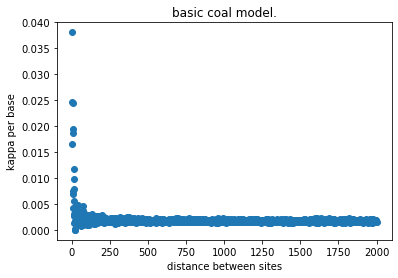

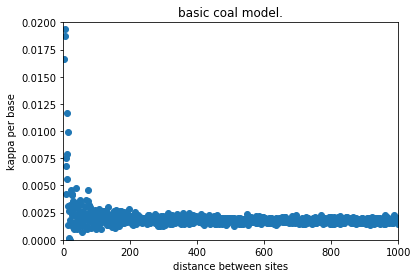

[0.00174368]


In [151]:

res_basic = [find_max_like_single_dist(x) for x in test_basic[:]]
x,y = zip(*res_basic)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("basic coal model.")
plt.show()

plt.xlim(0,1000)
plt.ylim(0,0.02)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("basic coal model.")
plt.show()

print(HeRho_estimate_one_chromosome(test_basic))

In [152]:
print(HeRho_estimate_one_chromosome(test_basic[100:]))
print(HeRho_estimate_one_chromosome(test_basic[200:]))
print(HeRho_estimate_one_chromosome(test_basic[500:]))

[0.00174284]
[0.00174031]
[0.00173083]


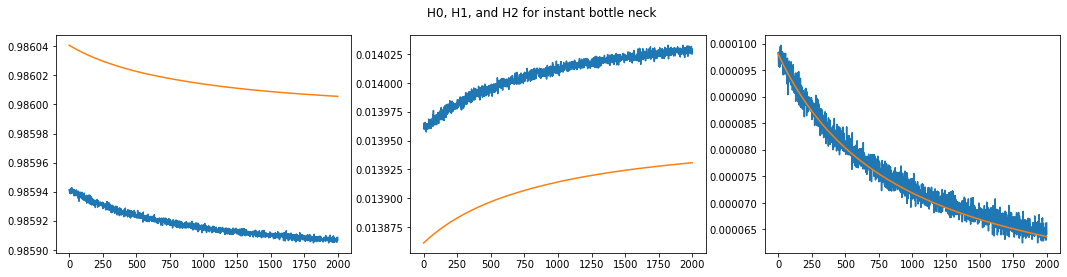

In [153]:
observed_hProbs_basic = np.apply_along_axis(lambda x: x/sum(x),1,test_basic[:,[1,2,3]])
expected_hProbs_basic = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_basic])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_basic[:,x])
    axs[x].plot(expected_hProbs_basic[:,x])
plt.show()

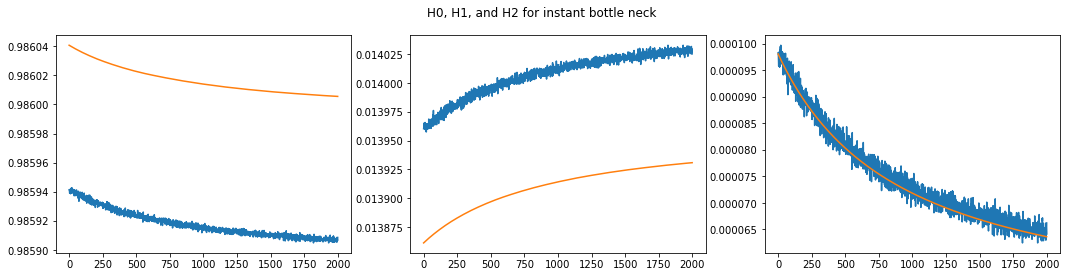

In [154]:
observed_hProbs_basic = np.apply_along_axis(lambda x: x/sum(x),1,test_basic[:,[1,2,3]])
expected_hProbs_basic = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_basic])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_basic[:,x])
    axs[x].plot(expected_hProbs_basic[:,x])
plt.show()

## Instantaneous bottleneck

Also have a function that runs the basic coalescent with a lower theta for comparison

returning for each replicate, the distance  matrix for herho input
which can be combined using "combine_rep_results()" to run optimization on.

##### sim_instant_bottleneck defined

In [155]:
def sim_instant_bottleneck(args): #in coal units
    itt, tBottle, tStrength = args
    theta = 0.0071
    rho = 0.0017
    mu = 5.4e-9
    Ne = theta/(4*mu)
    r = rho/(4*Ne)
    L=50e6
    maxDistance = 2000

    Tb = tBottle*2*Ne #gens pastward to bottleneck in 2Ne gens
    Ts = tStrength*2*Ne #duration of bottleneck in 2Ne gens

    demography = msprime.Demography()
    demography.add_population(initial_size=Ne)
    demography.add_instantaneous_bottleneck(time=Tb, strength=Ts, population=0)

    #This sets up a single neutral simulation given the parameters above: 
    ts = msprime.sim_ancestry(
        samples=1,
        demography=demography,
        ploidy=2,
        recombination_rate=r,
        sequence_length=L,
        discrete_genome=False,
    )

    mts = msprime.sim_mutations(ts, rate=mu)
    #print(mts.num_trees)
    #print(mts.num_mutations)


    # #records an array of ALL sites, indicating whether the site is homozygous (0) or heterozygous (1)
    # hetStates = np.zeros(int(L),dtype=int)
    # for x in mts.variants():
    #     hetStates[int(x.position)] = 1

    hetStates = get_het_states(mts)
    firstCompareSeq = get_compare_seq(hetStates)
    start = time.time()
    g = rolling_window(hetStates,firstCompareSeq, maxDistance)
    countsByDistance = sum(g)

    res = countsByDistance.transpose()
    resNorm = np.apply_along_axis(lambda x: x/sum(x),1,res)

    resDF = pd.DataFrame(data = res,columns=["h0","h1","h2"])
    resDF["theta"]=[1/2*p1 + p2 for p0,p1,p2 in resNorm]
    
    heroInput = [[a,b,c,d,e] for (a,[b,c,d,e]) in list(zip(range(1,2000+1),resDF.values.tolist()))]
    #heroInput = pd.DataFrame(heroInput,columns=["d","h0","h1","h2","H"])
    return(heroInput)

##### res instant bottleneck

In [156]:
test_instant_bottle = sim_instant_bottleneck([0,0.5,2.0])
test_instant_bottle = np.array(test_instant_bottle)

In [157]:
print(test_instant_bottle.tolist())

[[1.0, 49724568.0, 272998.0, 434.0, 0.002738769550782031], [2.0, 49724596.0, 272942.0, 462.0, 0.0027387695507820314], [3.0, 49724554.0, 273026.0, 420.0, 0.0027387695507820314], [4.0, 49724555.0, 273024.0, 421.0, 0.002738769550782031], [5.0, 49724553.0, 273028.0, 419.0, 0.002738769550782031], [6.0, 49724545.0, 273044.0, 411.0, 0.0027387695507820314], [7.0, 49724606.0, 272922.0, 472.0, 0.002738769550782031], [8.0, 49724574.0, 272986.0, 440.0, 0.002738769550782031], [9.0, 49724565.0, 273004.0, 431.0, 0.0027387695507820314], [10.0, 49724565.0, 273004.0, 431.0, 0.0027387695507820314], [11.0, 49724604.0, 272926.0, 470.0, 0.002738769550782031], [12.0, 49724567.0, 273000.0, 433.0, 0.0027387695507820314], [13.0, 49724610.0, 272914.0, 476.0, 0.0027387695507820314], [14.0, 49724581.0, 272972.0, 447.0, 0.0027387695507820314], [15.0, 49724541.0, 273052.0, 407.0, 0.0027387695507820314], [16.0, 49724544.0, 273046.0, 410.0, 0.0027387695507820314], [17.0, 49724601.0, 272932.0, 467.0, 0.0027387695507820

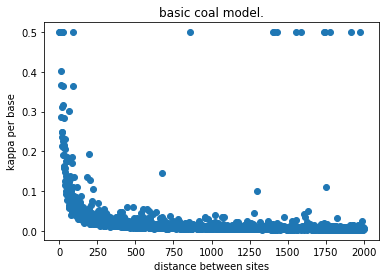

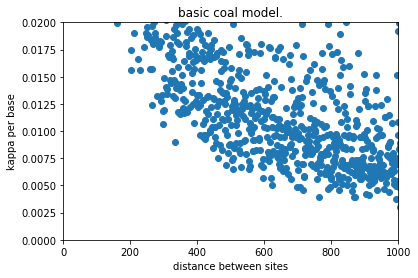

[0.02175403]


In [158]:

res_instant_bottle = [find_max_like_single_dist(x) for x in test_instant_bottle[:]]
x,y = zip(*res_instant_bottle)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("basic coal model.")
plt.show()

plt.xlim(0,1000)
plt.ylim(0,0.02)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("basic coal model.")
plt.show()

print(HeRho_estimate_one_chromosome(test_instant_bottle))

In [159]:
print(HeRho_estimate_one_chromosome(test_instant_bottle[100:]))
print(HeRho_estimate_one_chromosome(test_instant_bottle[200:]))
print(HeRho_estimate_one_chromosome(test_instant_bottle[500:]))

[0.01353744]
[0.01043595]
[0.00721471]


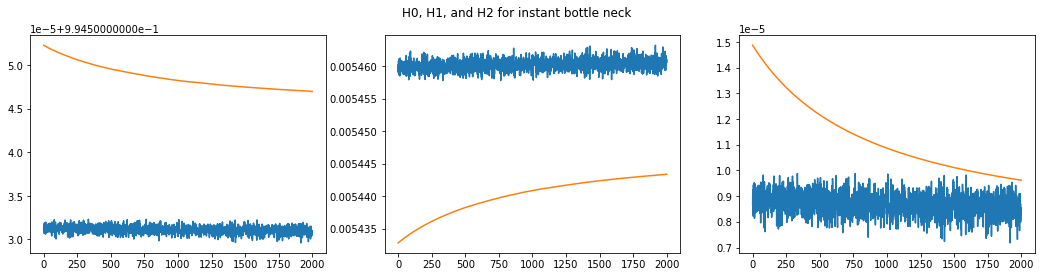

In [160]:
observed_hProbs_instant_bottle = np.apply_along_axis(lambda x: x/sum(x),1,test_instant_bottle[:,[1,2,3]])
expected_hProbs_instant_bottle = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_instant_bottle])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_instant_bottle[:,x])
    axs[x].plot(expected_hProbs_instant_bottle[:,x])
plt.show()

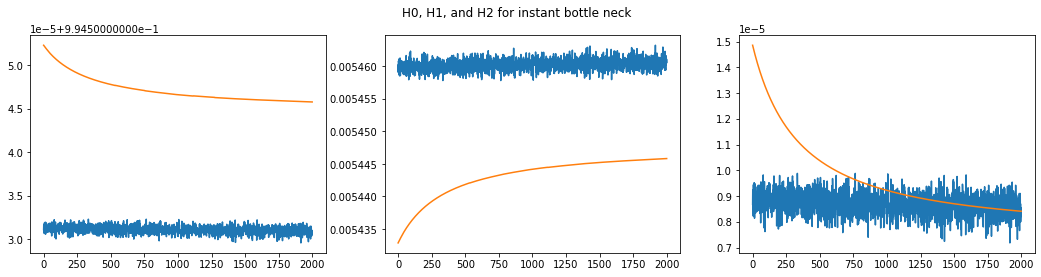

In [161]:
observed_hProbs_instant_bottle = np.apply_along_axis(lambda x: x/sum(x),1,test_instant_bottle[:,[1,2,3]])
expected_hProbs_instant_bottle = np.array([two_locus_het_probs(x[-1],0.0017*(0.0071/x[-1]),x[0]) for x in test_instant_bottle])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_instant_bottle[:,x])
    axs[x].plot(expected_hProbs_instant_bottle[:,x])
plt.show()

##### Probability of coal before, during, or after instant bottleneck and expected diversity 

In [ ]:
Tb = 0.5*2*Ne #gens pastward to bottleneck
Ts = 1.0*2*Ne #duration of bottleneck in gens

#probability of coalesence before, during, or after the bottleneck
#need to convert to coal units again for calculations, so use lowercase here. 
tb = Tb/(2*Ne) #time to bottleneck pastward in coal units
ts = Ts/(2*Ne) #duration of bottleneck in coal units
l = 1 #rate of coal in units of 2Ne

prBefore = (1 - math.exp(-l*tb))
prDuring = math.exp(-l*tb)*( 1 - math.exp(-l*ts))
prAfter = 1 - prBefore-prDuring #can also derive directly 

#expected time to coal, given coal before, during or after bottleneck

tCoalBefore = (1 - math.exp(tb*l)+tb*l)/(l*(1 - math.exp(tb*l))) #condition, normalize, recalculate mean
tCoalDuring = tb #msprime assumes no time occurs during bottleneck, so all occurs at tb. 
tCoalAfter = tb+1/l #time to beginning of bottleneck plus expected time to neutral coal 

meanTimeNeutral = 1/l
meanTimeBottleneck = prBefore*tCoalBefore+prDuring*tCoalDuring+prAfter*tCoalAfter

print(prBefore,prDuring,prAfter)
print(tCoalBefore,tCoalDuring,tCoalAfter)
print(meanTimeNeutral*0.0071,0.0071*meanTimeBottleneck)

## Bottleneck - NOT instantaneous

modeling a population bottleneck as a size change for a duration of time. current and ancestral pop sizes are Na.  Bottleneck pop size is Nb < Na. 

This effectively allows some mutation to occur during the bottle neck...

##### non-instant bottleneck simulation function def

In [162]:
def sim_bottleneck(args):
    itt, tBottle, tDuration,NBottleFrac = args
    theta = 0.0071
    rho = 0.0017
    mu = 5.4e-9
    Ne = theta/(4*mu)
    r = rho/(4*Ne)
    L=50e6
    maxDistance = 2000
    
    ##currently chosen to match probabilites to the instantaneous bottleneck model
    ## is there an effect of Ne change indepenednet of the duration? expectation has only compound params...
    #tBottle = 0.5
    #tDuration = 1.0/10
    Nbottle = NBottleFrac*Ne
    

    Tb = tBottle*2*Ne #gens pastward to bottleneck in 2Ne gens
    Td = tDuration*2*Ne #duration of bottleneck in 2Ne gens

    demography = msprime.Demography()
    demography.add_population(initial_size=Ne)
    demography.add_population_parameters_change(time=Tb,initial_size=Nbottle)
    demography.add_population_parameters_change(time=Tb+Td,initial_size=Ne)

    #This sets up a single neutral simulation given the parameters above: 
    ts = msprime.sim_ancestry(
        samples=1,
        demography=demography,
        ploidy=2,
        recombination_rate=r,
        sequence_length=L,
        discrete_genome=False,
    )

    mts = msprime.sim_mutations(ts, rate=mu)
    #print(mts.num_trees)
    #print(mts.num_mutations)


    # #records an array of ALL sites, indicating whether the site is homozygous (0) or heterozygous (1)
    # hetStates = np.zeros(int(L),dtype=int)
    # for x in mts.variants():
    #     hetStates[int(x.position)] = 1

    hetStates = get_het_states(mts)
    firstCompareSeq = get_compare_seq(hetStates)
    start = time.time()
    g = rolling_window(hetStates,firstCompareSeq, maxDistance)
    countsByDistance = sum(g)

    res = countsByDistance.transpose()
    resNorm = np.apply_along_axis(lambda x: x/sum(x),1,res)

    resDF = pd.DataFrame(data = res,columns=["h0","h1","h2"])
    resDF["theta"]=[1/2*p1 + p2 for p0,p1,p2 in resNorm]
    
    heroInput = [[a,b,c,d,e] for (a,[b,c,d,e]) in list(zip(range(1,2000+1),resDF.values.tolist()))]
    #heroInput = pd.DataFrame(heroInput,columns=["d","h0","h1","h2","H"])
    return(heroInput)

##### short strong bottleneck
Tbottle= 0.5
duration of bottleneck = 0.1
pop size bottleneck = 0.1 * Ne


For duration Nb = 1/10 Na, Tduration = 1/10. That way prob of coal during bottlelenck is same as above (Tduration * 1/ nb =  1.0, matching duration of 'instantaneous bottleneck' above.


In [163]:
test_bottle_strong_short = sim_bottleneck([0,0.5,1.0/10,1/10])
test_bottle_strong_short = np.array(test_bottle_strong_short)

In [164]:
print(test_bottle_strong_short.tolist())

[[1.0, 49545702.0, 449996.0, 2302.0, 0.004546181847273891], [2.0, 49545584.0, 450232.0, 2184.0, 0.0045461818472738915], [3.0, 49545683.0, 450034.0, 2283.0, 0.0045461818472738915], [4.0, 49545735.0, 449930.0, 2335.0, 0.004546181847273891], [5.0, 49545632.0, 450136.0, 2232.0, 0.0045461818472738915], [6.0, 49545687.0, 450026.0, 2287.0, 0.0045461818472738915], [7.0, 49545587.0, 450226.0, 2187.0, 0.004546181847273891], [8.0, 49545633.0, 450134.0, 2233.0, 0.004546181847273891], [9.0, 49545720.0, 449960.0, 2320.0, 0.0045461818472738915], [10.0, 49545683.0, 450034.0, 2283.0, 0.0045461818472738915], [11.0, 49545674.0, 450052.0, 2274.0, 0.0045461818472738915], [12.0, 49545697.0, 450006.0, 2297.0, 0.004546181847273891], [13.0, 49545691.0, 450018.0, 2291.0, 0.0045461818472738915], [14.0, 49545668.0, 450064.0, 2268.0, 0.004546181847273891], [15.0, 49545671.0, 450058.0, 2271.0, 0.004546181847273891], [16.0, 49545710.0, 449980.0, 2310.0, 0.004546181847273891], [17.0, 49545652.0, 450096.0, 2252.0, 0.0

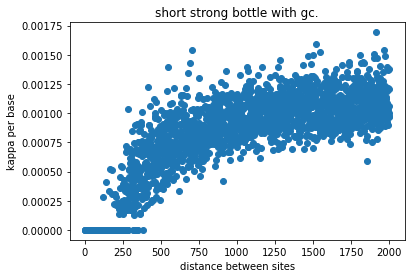

[0.00093547]


In [165]:
res_bottle_strong_short = [find_max_like_single_dist(x) for x in test_bottle_strong_short[:]]
x,y = zip(*res_bottle_strong_short)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("short strong bottle with gc.")
plt.show()
print(HeRho_estimate_one_chromosome(test_bottle_strong_short))

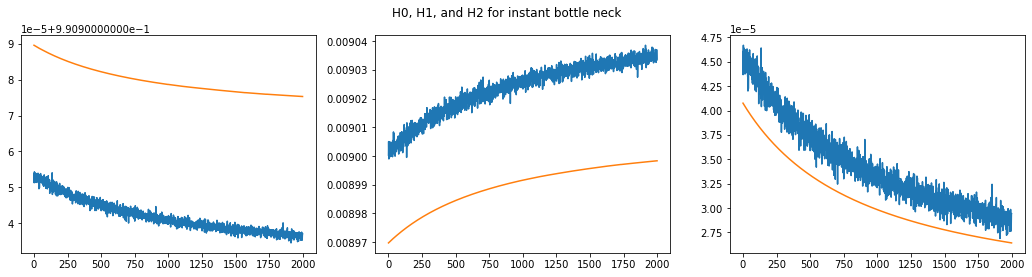

In [166]:
observed_hProbs_bottle_strong_short = np.apply_along_axis(lambda x: x/sum(x),1,test_bottle_strong_short[:,[1,2,3]])
expected_hProbs_bottle_strong_short = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_bottle_strong_short])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_bottle_strong_short[:,x])
    axs[x].plot(expected_hProbs_bottle_strong_short[:,x])
plt.show()

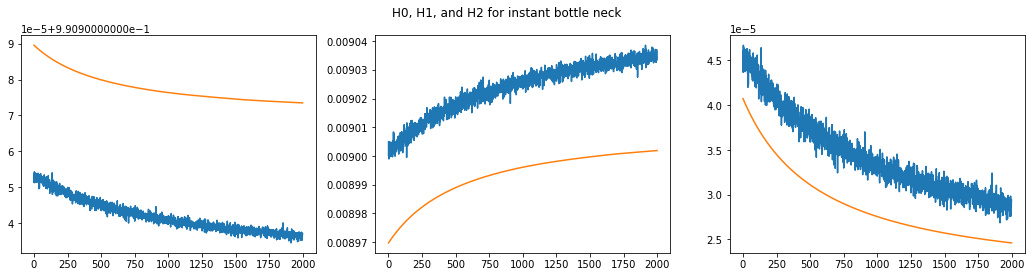

In [167]:
observed_hProbs_bottle_strong_short = np.apply_along_axis(lambda x: x/sum(x),1,test_bottle_strong_short[:,[1,2,3]])
expected_hProbs_bottle_strong_short = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_bottle_strong_short])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_bottle_strong_short[:,x])
    axs[x].plot(expected_hProbs_bottle_strong_short[:,x])
plt.show()

##### weak long bottltneck sim function defined (also needs better name) 

still using parameters to match prob of coal during bottleneck in instantaneous and strong bottleneck models above

tBottle = 0.5
tDuration = 0.9
Nbottle = 0.9 * Ne

duration Nb = 1/10 Na, so Tduration = 1/10. That way prob of coal during bottlelenck is same as above (Tduration * 1/ nb =  1.0, matching duration of 'instantaneous bottleneck' above. 


In [168]:
test_bottle_weak_long = sim_bottleneck([0,0.5,0.9,0.9])
test_bottle_weak_long = np.array(test_bottle_weak_long)

In [169]:
print(test_bottle_weak_long.tolist())

[[1.0, 49319535.0, 673894.0, 4571.0, 0.006830633225329013], [2.0, 49319549.0, 673866.0, 4585.0, 0.006830633225329013], [3.0, 49319572.0, 673820.0, 4608.0, 0.006830633225329013], [4.0, 49319520.0, 673924.0, 4556.0, 0.006830633225329013], [5.0, 49319574.0, 673816.0, 4610.0, 0.006830633225329013], [6.0, 49319487.0, 673990.0, 4523.0, 0.006830633225329013], [7.0, 49319483.0, 673998.0, 4519.0, 0.006830633225329013], [8.0, 49319542.0, 673880.0, 4578.0, 0.006830633225329013], [9.0, 49319424.0, 674116.0, 4460.0, 0.006830633225329013], [10.0, 49319464.0, 674036.0, 4500.0, 0.006830633225329013], [11.0, 49319546.0, 673872.0, 4582.0, 0.006830633225329012], [12.0, 49319579.0, 673806.0, 4615.0, 0.006830633225329013], [13.0, 49319561.0, 673842.0, 4597.0, 0.006830633225329013], [14.0, 49319468.0, 674028.0, 4504.0, 0.006830633225329013], [15.0, 49319526.0, 673912.0, 4562.0, 0.006830633225329013], [16.0, 49319524.0, 673916.0, 4560.0, 0.006830633225329013], [17.0, 49319430.0, 674104.0, 4466.0, 0.006830633

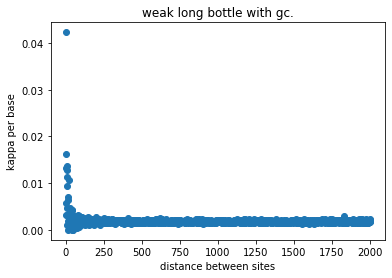

[0.00179862]


In [170]:
res_bottle_weak_long = [find_max_like_single_dist(x) for x in test_bottle_weak_long[:]]
x,y = zip(*res_bottle_weak_long)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("weak long bottle with gc.")
plt.show()
print(HeRho_estimate_one_chromosome(test_bottle_weak_long))

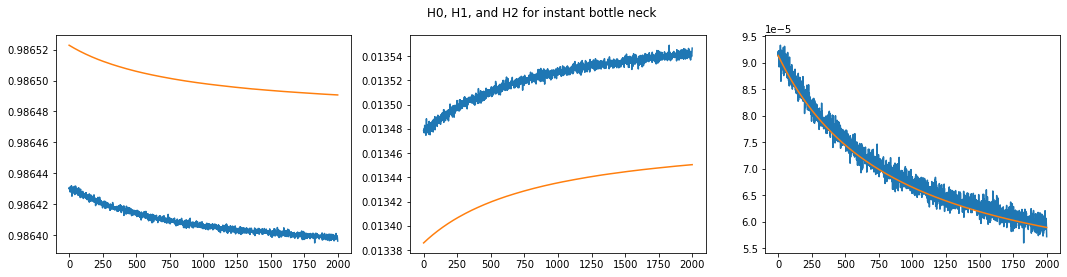

In [171]:
observed_hProbs_bottle_weak_long = np.apply_along_axis(lambda x: x/sum(x),1,test_bottle_weak_long[:,[1,2,3]])
expected_hProbs_bottle_weak_long = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_bottle_weak_long])
#expected_hProbs_bottle_weak_long = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_bottle_weak_long])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_bottle_weak_long[:,x])
    axs[x].plot(expected_hProbs_bottle_weak_long[:,x])
plt.show()

##### mid strength bottleneck 

still using parameters to match prob of coal during bottleneck in instantaneous and strong bottleneck models above


duration Nb = 1/2 Na, so Tduration = 1/2. That way prob of coal during bottlelenck is same as above (Tduration * 1/ nb =  1.0, matching duration of 'instantaneous bottleneck' above. 


In [172]:
test_bottle_mid_strength = sim_bottleneck([0,0.5,0.5,0.5])
test_bottle_mid_strength = np.array(test_bottle_mid_strength)

In [173]:
print(test_bottle_mid_strength.tolist())

[[1.0, 49425228.0, 569440.0, 3332.0, 0.005761270450818033], [2.0, 49425207.0, 569482.0, 3311.0, 0.005761270450818033], [3.0, 49425233.0, 569430.0, 3337.0, 0.005761270450818033], [4.0, 49425269.0, 569358.0, 3373.0, 0.005761270450818033], [5.0, 49425229.0, 569438.0, 3333.0, 0.005761270450818033], [6.0, 49425153.0, 569590.0, 3257.0, 0.005761270450818033], [7.0, 49425174.0, 569548.0, 3278.0, 0.005761270450818033], [8.0, 49425206.0, 569484.0, 3310.0, 0.005761270450818033], [9.0, 49425275.0, 569346.0, 3379.0, 0.005761270450818033], [10.0, 49425246.0, 569404.0, 3350.0, 0.005761270450818033], [11.0, 49425201.0, 569494.0, 3305.0, 0.005761270450818033], [12.0, 49425329.0, 569238.0, 3433.0, 0.005761270450818033], [13.0, 49425309.0, 569278.0, 3413.0, 0.005761270450818033], [14.0, 49425029.0, 569838.0, 3133.0, 0.005761270450818033], [15.0, 49425276.0, 569344.0, 3380.0, 0.005761270450818033], [16.0, 49425280.0, 569336.0, 3384.0, 0.005761270450818033], [17.0, 49425240.0, 569416.0, 3344.0, 0.005761270

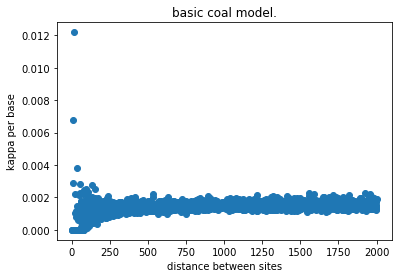

[0.00150643]


In [174]:


res_bottle_mid_strength = [find_max_like_single_dist(x) for x in test_bottle_mid_strength[:]]
x,y = zip(*res_bottle_mid_strength)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("basic coal model.")
plt.show()
print(HeRho_estimate_one_chromosome(test_bottle_mid_strength))

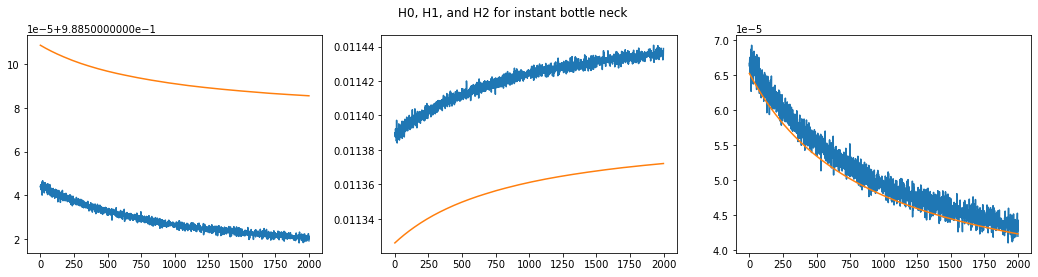

In [175]:
observed_hProbs_bottle_mid_strength = np.apply_along_axis(lambda x: x/sum(x),1,test_bottle_mid_strength[:,[1,2,3]])
expected_hProbs_bottle_mid_strength = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_bottle_mid_strength])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_bottle_mid_strength[:,x])
    axs[x].plot(expected_hProbs_bottle_mid_strength[:,x])
plt.show()

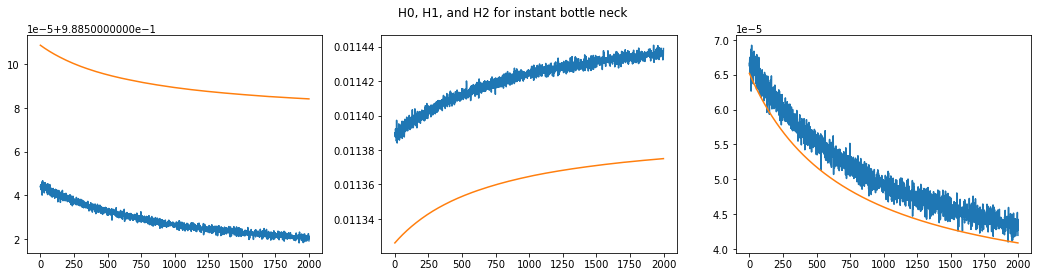

In [176]:
observed_hProbs_bottle_mid_strength = np.apply_along_axis(lambda x: x/sum(x),1,test_bottle_mid_strength[:,[1,2,3]])
expected_hProbs_bottle_mid_strength = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_bottle_mid_strength])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_bottle_mid_strength[:,x])
    axs[x].plot(expected_hProbs_bottle_mid_strength[:,x])
plt.show()

##### bottleneck model scaled results combined

In [177]:
scaledRes_bottle_strong_short = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_bottle_strong_short,test_bottle_strong_short[:,-1],scaled_rho_expected))];
scaledRes_bottle_weak_long = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_bottle_weak_long,test_bottle_weak_long[:,-1],scaled_rho_expected))];
scaledRes_bottle_mid_strength = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_bottle_mid_strength,test_bottle_mid_strength[:,-1],scaled_rho_expected))];


In [178]:
print("true rho/theta = 0.239437")
print([a[1] for a in scaledRes_bottle_strong_short[-6:-1]])
print([a[1] for a in scaledRes_bottle_weak_long[-6:-1]])
print([a[1] for a in scaledRes_bottle_mid_strength[-6:-1]])
print("true rho/theta = 0.239437")


true rho/theta = 0.239437
[1.2546761050516677, 0.9205420928657493, 1.1100611342706543, 1.2683870108512318, 0.9778153725987522]
[1.062900220796804, 0.9897871071740068, 0.9931350583316563, 1.1116082146578512, 1.13864849033527]
[1.0937212109183907, 0.9173368367897088, 0.8941787374015354, 1.2581035987578535, 1.0064998055048922]
true rho/theta = 0.239437


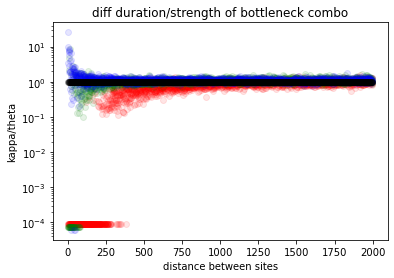

In [179]:


x,y = zip(*scaledRes_bottle_strong_short)
plt.scatter(x,y,color='red',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_bottle_mid_strength)
plt.scatter(x,y,color='green',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_bottle_weak_long)
plt.scatter(x,y,color='blue',alpha=0.1,edgecolors=None)

# x,y = zip(*scaled_rho_expected)
# plt.scatter(x,y,color='black')
x=range(1,2000)
y=[1 for x in range(1,2000)]
plt.scatter(x,y,color='black',alpha=0.1,edgecolors=None)


plt.yscale("log")
plt.xlabel("distance between sites")
plt.ylabel("kappa/theta")
plt.title("diff duration/strength of bottleneck combo")
plt.show()

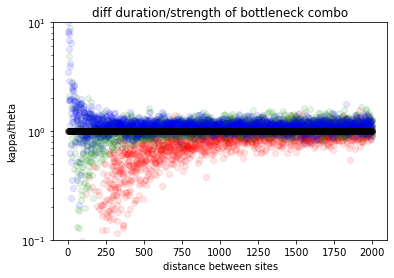

In [180]:
x,y = zip(*scaledRes_bottle_strong_short)
plt.scatter(x,y,color='red',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_bottle_mid_strength)
plt.scatter(x,y,color='green',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_bottle_weak_long)
plt.scatter(x,y,color='blue',alpha=0.1,edgecolors=None)

# x,y = zip(*scaled_rho_expected)
# plt.scatter(x,y,color='black')
x=range(1,2000)
y=[1 for x in range(1,2000)]
plt.scatter(x,y,color='black',alpha=0.1,edgecolors=None)


plt.yscale("log")
plt.ylim(1e-1,1e1)
plt.xlabel("distance between sites")
plt.ylabel("kappa/theta")
plt.title("diff duration/strength of bottleneck combo")
plt.show()

## Exponential growth model 

##### exponential growth model defined

In [181]:
def sim_exponential_growth(args):
    itt, c, Ta = args  
    #itt = identifier, c = reduction in pop size. I.e. Na = c*Ne
    # Ta = time when pop size reaches Na in coal time units
        
    theta = 0.0071
    rho = 0.0017
    mu = 5.4e-9
    Ne = theta/(4*mu)
    r = rho/(4*Ne)
    L=50e6
    maxDistance = 2000
    
    Na = Ne*c
    ta = 2*Ne*Ta
    growth_rate = -math.log(1/10)/ta
    

    

    demography = msprime.Demography()
    demography.add_population(initial_size=Ne,growth_rate=growth_rate)
    demography.add_population_parameters_change(time=ta,initial_size=Na)


    #This sets up a single neutral simulation given the parameters above: 
    ts = msprime.sim_ancestry(
        samples=1,
        demography=demography,
        ploidy=2,
        recombination_rate=r,
        sequence_length=L,
        discrete_genome=False,
    )

    mts = msprime.sim_mutations(ts, rate=mu)
    #print(mts.num_trees)
    #print(mts.num_mutations)


    # #records an array of ALL sites, indicating whether the site is homozygous (0) or heterozygous (1)
    # hetStates = np.zeros(int(L),dtype=int)
    # for x in mts.variants():
    #     hetStates[int(x.position)] = 1

    hetStates = get_het_states(mts)
    firstCompareSeq = get_compare_seq(hetStates)
    start = time.time()
    g = rolling_window(hetStates,firstCompareSeq, maxDistance)
    countsByDistance = sum(g)

    res = countsByDistance.transpose()
    resNorm = np.apply_along_axis(lambda x: x/sum(x),1,res)

    resDF = pd.DataFrame(data = res,columns=["h0","h1","h2"])
    resDF["theta"]=[1/2*p1 + p2 for p0,p1,p2 in resNorm]
    
    heroInput = [[a,b,c,d,e] for (a,[b,c,d,e]) in list(zip(range(1,2000+1),resDF.values.tolist()))]
    #heroInput = pd.DataFrame(heroInput,columns=["d","h0","h1","h2","H"])
    return(heroInput)

##### __Strong and very recent exponential growth__

pop reduces to 1/10 the size 0.025 (2N) generations in the past

In [182]:
veryRecentExponential = sim_exponential_growth([0,1/10,0.05])
veryRecentExponential = np.array(veryRecentExponential)

In [183]:
print(veryRecentExponential.tolist())

[[1.0, 49944981.0, 53002.0, 17.0, 0.00053038121524861], [2.0, 49944984.0, 52996.0, 20.0, 0.00053038121524861], [3.0, 49944980.0, 53004.0, 16.0, 0.00053038121524861], [4.0, 49944985.0, 52994.0, 21.0, 0.00053038121524861], [5.0, 49944983.0, 52998.0, 19.0, 0.00053038121524861], [6.0, 49944982.0, 53000.0, 18.0, 0.00053038121524861], [7.0, 49944983.0, 52998.0, 19.0, 0.00053038121524861], [8.0, 49944977.0, 53010.0, 13.0, 0.00053038121524861], [9.0, 49944979.0, 53006.0, 15.0, 0.00053038121524861], [10.0, 49944975.0, 53014.0, 11.0, 0.00053038121524861], [11.0, 49944981.0, 53002.0, 17.0, 0.00053038121524861], [12.0, 49944978.0, 53008.0, 14.0, 0.0005303812152486099], [13.0, 49944980.0, 53004.0, 16.0, 0.00053038121524861], [14.0, 49944977.0, 53010.0, 13.0, 0.00053038121524861], [15.0, 49944985.0, 52994.0, 21.0, 0.00053038121524861], [16.0, 49944980.0, 53004.0, 16.0, 0.00053038121524861], [17.0, 49944978.0, 53008.0, 14.0, 0.0005303812152486099], [18.0, 49944983.0, 52998.0, 19.0, 0.0005303812152486

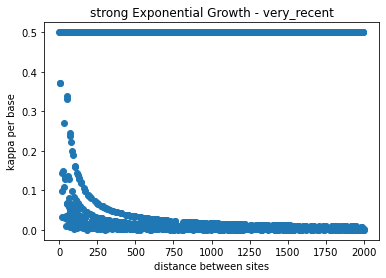

[0.11864448]


In [184]:
res_exponential_singleItt = [find_max_like_single_dist(x) for x in veryRecentExponential[:]]
x,y = zip(*res_exponential_singleItt)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("strong Exponential Growth - very_recent")
plt.show()
print(HeRho_estimate_one_chromosome(veryRecentExponential))

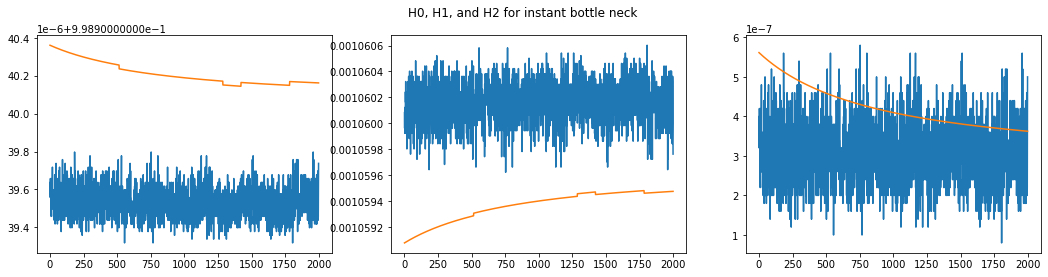

In [185]:
observed_hProbs_bottle_veryRecentExponential = np.apply_along_axis(lambda x: x/sum(x),1,veryRecentExponential[:,[1,2,3]])
expected_hProbs_bottle_veryRecentExponential = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in veryRecentExponential])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_bottle_veryRecentExponential[:,x])
    axs[x].plot(expected_hProbs_bottle_veryRecentExponential[:,x])
plt.show()

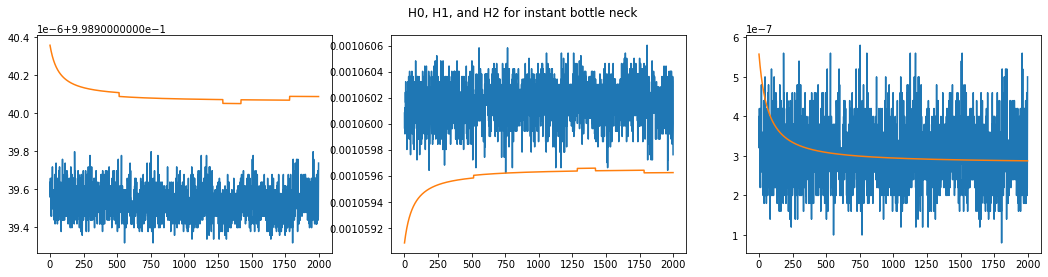

In [186]:
observed_hProbs_bottle_veryRecentExponential = np.apply_along_axis(lambda x: x/sum(x),1,veryRecentExponential[:,[1,2,3]])
expected_hProbs_bottle_veryRecentExponential = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in veryRecentExponential])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_bottle_veryRecentExponential[:,x])
    axs[x].plot(expected_hProbs_bottle_veryRecentExponential[:,x])
plt.show()

##### __Strong and recent exponential growth__

pop reduces to 1/10 the size 0.5 (2N) generations in the past

In [187]:
strongRecentExponential = sim_exponential_growth([0,1/10,0.5])
strongRecentExponential = np.array(strongRecentExponential)

In [188]:
print(strongRecentExponential.tolist())

[[1.0, 49776682.0, 221012.0, 306.0, 0.0022163286531461258], [2.0, 49776685.0, 221006.0, 309.0, 0.002216328653146126], [3.0, 49776654.0, 221068.0, 278.0, 0.0022163286531461258], [4.0, 49776691.0, 220994.0, 315.0, 0.0022163286531461258], [5.0, 49776678.0, 221020.0, 302.0, 0.0022163286531461258], [6.0, 49776673.0, 221030.0, 297.0, 0.0022163286531461258], [7.0, 49776696.0, 220984.0, 320.0, 0.0022163286531461258], [8.0, 49776697.0, 220982.0, 321.0, 0.0022163286531461258], [9.0, 49776678.0, 221020.0, 302.0, 0.0022163286531461258], [10.0, 49776668.0, 221040.0, 292.0, 0.002216328653146126], [11.0, 49776688.0, 221000.0, 312.0, 0.0022163286531461258], [12.0, 49776682.0, 221012.0, 306.0, 0.0022163286531461258], [13.0, 49776699.0, 220978.0, 323.0, 0.0022163286531461258], [14.0, 49776721.0, 220934.0, 345.0, 0.002216328653146126], [15.0, 49776698.0, 220980.0, 322.0, 0.0022163286531461258], [16.0, 49776684.0, 221008.0, 308.0, 0.0022163286531461258], [17.0, 49776702.0, 220972.0, 326.0, 0.0022163286531

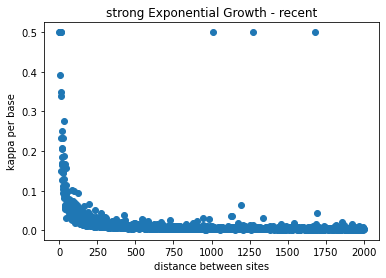

[0.0083786]


In [189]:
res_exponential_recent = [find_max_like_single_dist(x) for x in strongRecentExponential[:]]
x,y = zip(*res_exponential_recent)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("strong Exponential Growth - recent")
plt.show()
print(HeRho_estimate_one_chromosome(strongRecentExponential))

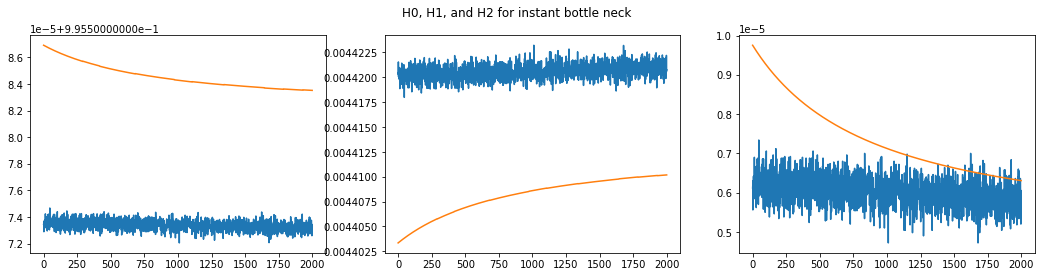

In [190]:
observed_hProbs_bottle_strongRecentExponential = np.apply_along_axis(lambda x: x/sum(x),1,strongRecentExponential[:,[1,2,3]])
expected_hProbs_bottle_strongRecentExponential = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in strongRecentExponential])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_bottle_strongRecentExponential[:,x])
    axs[x].plot(expected_hProbs_bottle_strongRecentExponential[:,x])
plt.show()

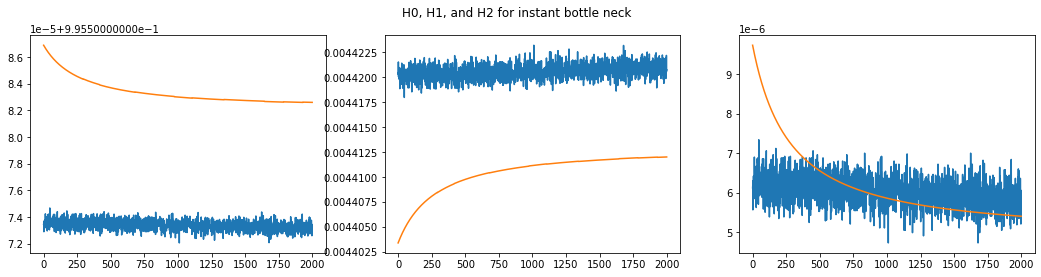

In [191]:
observed_hProbs_bottle_strongRecentExponential = np.apply_along_axis(lambda x: x/sum(x),1,strongRecentExponential[:,[1,2,3]])
expected_hProbs_bottle_strongRecentExponential = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in strongRecentExponential])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_bottle_strongRecentExponential[:,x])
    axs[x].plot(expected_hProbs_bottle_strongRecentExponential[:,x])
plt.show()

##### __Strong and older exponential growth__
Pop size reduces (pastward) to 1/10th the size at 2*2Ne generations in the past 

In [192]:
strongOlderExponential = sim_exponential_growth([0,1/10,2.0])

In [193]:
strongOlderExponential = np.array(strongOlderExponential)

In [194]:
print(strongOlderExponential.tolist())

[[1.0, 49594908.0, 401900.0, 1192.0, 0.004043001720068803], [2.0, 49594862.0, 401992.0, 1146.0, 0.004043001720068802], [3.0, 49594883.0, 401950.0, 1167.0, 0.004043001720068802], [4.0, 49594921.0, 401874.0, 1205.0, 0.004043001720068803], [5.0, 49594898.0, 401920.0, 1182.0, 0.004043001720068802], [6.0, 49594911.0, 401894.0, 1195.0, 0.004043001720068803], [7.0, 49594915.0, 401886.0, 1199.0, 0.004043001720068802], [8.0, 49594929.0, 401858.0, 1213.0, 0.004043001720068803], [9.0, 49594885.0, 401946.0, 1169.0, 0.004043001720068802], [10.0, 49594915.0, 401886.0, 1199.0, 0.004043001720068802], [11.0, 49594910.0, 401896.0, 1194.0, 0.004043001720068802], [12.0, 49594875.0, 401966.0, 1159.0, 0.004043001720068802], [13.0, 49594840.0, 402036.0, 1124.0, 0.004043001720068803], [14.0, 49594964.0, 401788.0, 1248.0, 0.004043001720068802], [15.0, 49594957.0, 401802.0, 1241.0, 0.004043001720068802], [16.0, 49594960.0, 401796.0, 1244.0, 0.004043001720068802], [17.0, 49594921.0, 401874.0, 1205.0, 0.004043001

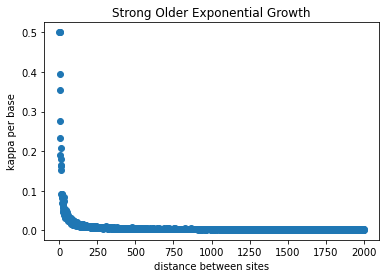

[0.00387174]


In [195]:
res_exponential_older = [find_max_like_single_dist(x) for x in strongOlderExponential[:]]
x,y = zip(*res_exponential_older)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("Strong Older Exponential Growth")
plt.show()
print(HeRho_estimate_one_chromosome(strongOlderExponential))

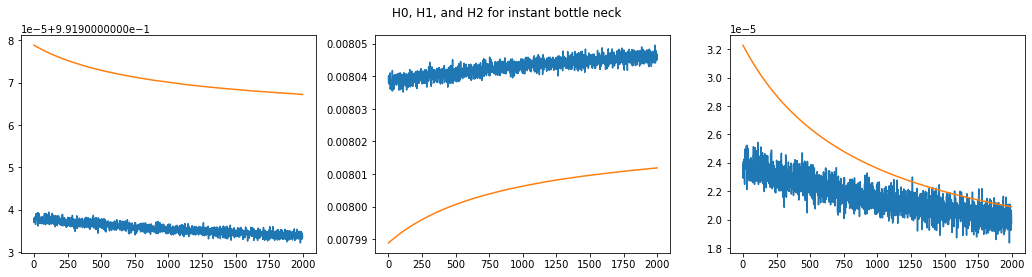

In [196]:
observed_hProbs_bottle_strongOlderExponential = np.apply_along_axis(lambda x: x/sum(x),1,strongOlderExponential[:,[1,2,3]])
expected_hProbs_bottle_strongOlderExponential = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in strongOlderExponential])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_bottle_strongOlderExponential[:,x])
    axs[x].plot(expected_hProbs_bottle_strongOlderExponential[:,x])
plt.show()

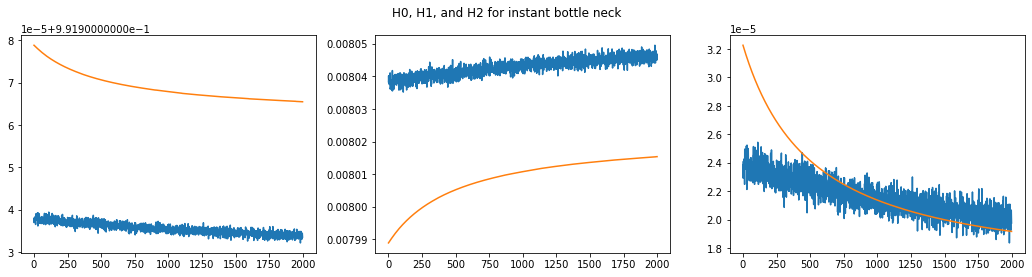

In [197]:
observed_hProbs_bottle_strongOlderExponential = np.apply_along_axis(lambda x: x/sum(x),1,strongOlderExponential[:,[1,2,3]])
expected_hProbs_bottle_strongOlderExponential = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in strongOlderExponential])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_bottle_strongOlderExponential[:,x])
    axs[x].plot(expected_hProbs_bottle_strongOlderExponential[:,x])
plt.show()

##### exponential scaled results combined

In [105]:
#[two_locus_het_probs(0.0071,0.0017,x) for x in range(1,100)]

In [198]:
scaledRes_exponential_veryrecent = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_exponential_singleItt,veryRecentExponential[:,-1],scaled_rho_expected))];
scaledRes_exponential_recent = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_exponential_recent,strongRecentExponential[:,-1],scaled_rho_expected))];
scaledRes_exponential_older = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_exponential_older,strongOlderExponential[:,-1],scaled_rho_expected))];


In [199]:
print("true rho/theta = 0.239437")
print([a[1] for a in scaledRes_exponential_veryrecent[-6:-1]])
print([a[1] for a in scaledRes_exponential_recent[-6:-1]])
print([a[1] for a in scaledRes_exponential_older[-6:-1]])

true rho/theta = 0.239437
[3.3195084185044066, 5.856024345370205, 10.287538081508586, 3937.234641952414, 3937.234641952414]
[3.1375964557720977, 5.694266942681545, 5.993228512972965, 4.212009463387963, 18.034976597632507]
[3.194715515982183, 1.971861649197811, 2.6398577993431314, 2.5848934587143217, 1.9923521863961668]


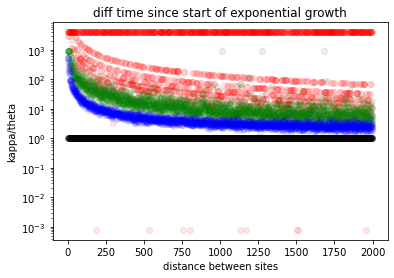

In [200]:
x,y = zip(*scaledRes_exponential_veryrecent)
plt.scatter(x,y,color='red',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_exponential_recent)
plt.scatter(x,y,color='green',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_exponential_older)
plt.scatter(x,y,color='blue',alpha=0.1,edgecolors=None)

x=range(1,2000)
y=[1 for x in range(1,2000)]
plt.scatter(x,y,color='black',alpha=0.1,edgecolors=None)

plt.yscale("log")
plt.xlabel("distance between sites")
plt.ylabel("kappa/theta")
plt.title("diff time since start of exponential growth")
plt.show()

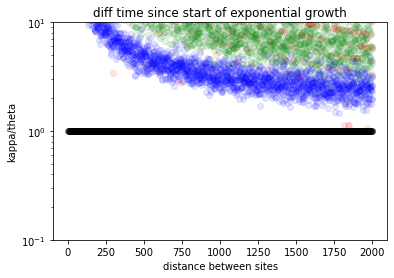

In [201]:
x,y = zip(*scaledRes_exponential_veryrecent)
plt.scatter(x,y,color='red',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_exponential_recent)
plt.scatter(x,y,color='green',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_exponential_older)
plt.scatter(x,y,color='blue',alpha=0.1,edgecolors=None)

x=range(1,2000)
y=[1 for x in range(1,2000)]
plt.scatter(x,y,color='black',alpha=0.1,edgecolors=None)

plt.yscale("log")
plt.ylim(1e-1,1e1)
plt.xlabel("distance between sites")
plt.ylabel("kappa/theta")
plt.title("diff time since start of exponential growth")
plt.show()

## Admixture Model 

##### sim_admixture defined

In [202]:
def sim_admixture(args):
    itt, Tadmix, Tdiv = args
    itt, c, Ta = args  
    #itt = identifier
    #Tadmix is time to admixture event in coal units
    #Tdiv is duration (!) of the divergence period 
        
    theta = 0.0071
    rho = 0.0017
    mu = 5.4e-9
    Ne = theta/(4*mu)
    r = rho/(4*Ne)
    L=50e6
    maxDistance = 2000
    
    tadmix = Tadmix*2*Ne
    tanc = (Tadmix + Tdiv)*2*Ne
    
    
    demography = msprime.Demography()
    demography.add_population(name="A", initial_size=Ne)
    demography.add_population(name="B", initial_size=Ne)
    demography.add_population(name="ADMIX", initial_size=Ne)
    demography.add_population(name="ANC", initial_size=Ne)
    demography.add_admixture(
        time=tadmix, derived="ADMIX", ancestral=["A", "B"], proportions=[0.5, 0.5])
    demography.add_population_split(time=tanc, derived=["A", "B"], ancestral="ANC")


    #This sets up a single neutral simulation given the parameters above: 
    ts = msprime.sim_ancestry(
        samples={"ADMIX":1},
        demography=demography,
        ploidy=2,
        recombination_rate=r,
        sequence_length=L,
        discrete_genome=False,
    )

    mts = msprime.sim_mutations(ts, rate=mu)
    #print(mts.num_trees)
    #print(mts.num_mutations)


    # #records an array of ALL sites, indicating whether the site is homozygous (0) or heterozygous (1)
    # hetStates = np.zeros(int(L),dtype=int)
    # for x in mts.variants():
    #     hetStates[int(x.position)] = 1

    hetStates = get_het_states(mts)
    firstCompareSeq = get_compare_seq(hetStates)
    start = time.time()
    g = rolling_window(hetStates,firstCompareSeq, maxDistance)
    countsByDistance = sum(g)

    res = countsByDistance.transpose()
    resNorm = np.apply_along_axis(lambda x: x/sum(x),1,res)

    resDF = pd.DataFrame(data = res,columns=["h0","h1","h2"])
    resDF["theta"]=[1/2*p1 + p2 for p0,p1,p2 in resNorm]
    
    heroInput = [[a,b,c,d,e] for (a,[b,c,d,e]) in list(zip(range(1,2000+1),resDF.values.tolist()))]
    #heroInput = pd.DataFrame(heroInput,columns=["d","h0","h1","h2","H"])
    return(heroInput)

In [128]:
#sim_admixture(["itt1",0.5,2])

##### __admixture model 1__
time to admixture is (0.01) 2 Ne gens
duration of divergence is (2.0)2 Ne gens
so time to divergence is (0.01 + 2.0) 2 Ne gens

In [203]:
test_admixture_1 = sim_admixture([0,0.01,2.0])
test_admixture_1 = np.array(test_admixture_1)

In [204]:
print(test_admixture_1.tolist())

[[1.0, 48597071.0, 1385930.0, 14999.0, 0.014159846393855754], [2.0, 48597007.0, 1386058.0, 14935.0, 0.014159846393855754], [3.0, 48596843.0, 1386386.0, 14771.0, 0.014159846393855754], [4.0, 48596874.0, 1386324.0, 14802.0, 0.014159846393855756], [5.0, 48597067.0, 1385938.0, 14995.0, 0.014159846393855754], [6.0, 48596752.0, 1386568.0, 14680.0, 0.014159846393855754], [7.0, 48596979.0, 1386114.0, 14907.0, 0.014159846393855754], [8.0, 48597246.0, 1385580.0, 15174.0, 0.014159846393855754], [9.0, 48596729.0, 1386614.0, 14657.0, 0.014159846393855754], [10.0, 48597160.0, 1385752.0, 15088.0, 0.014159846393855754], [11.0, 48597077.0, 1385918.0, 15005.0, 0.014159846393855754], [12.0, 48596968.0, 1386136.0, 14896.0, 0.014159846393855756], [13.0, 48596905.0, 1386262.0, 14833.0, 0.014159846393855754], [14.0, 48596789.0, 1386494.0, 14717.0, 0.014159846393855756], [15.0, 48596971.0, 1386130.0, 14899.0, 0.014159846393855754], [16.0, 48597003.0, 1386066.0, 14931.0, 0.014159846393855754], [17.0, 48596824.

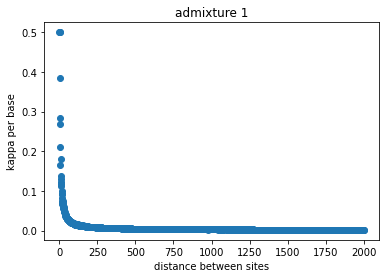

[0.00338715]


In [205]:
res_admixture_1 = [find_max_like_single_dist(x) for x in test_admixture_1[:]]
x,y = zip(*res_admixture_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("admixture 1")
plt.show()
print(HeRho_estimate_one_chromosome(test_admixture_1))

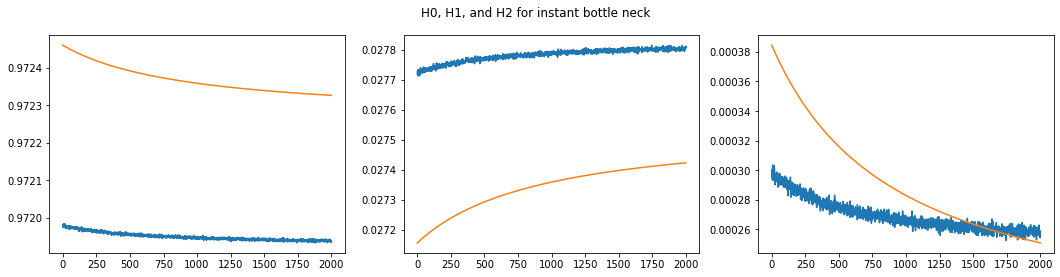

In [206]:
observed_hProbs_admixture_1 = np.apply_along_axis(lambda x: x/sum(x),1,test_admixture_1[:,[1,2,3]])
expected_hProbs_admixture_1 = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_admixture_1])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_admixture_1[:,x])
    axs[x].plot(expected_hProbs_admixture_1[:,x])
plt.show()

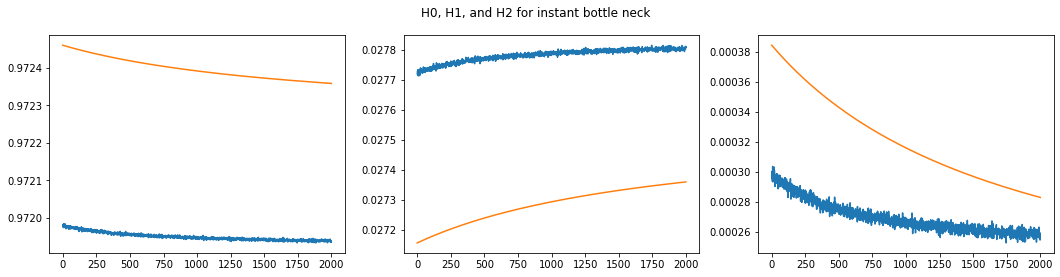

In [207]:
observed_hProbs_admixture_1 = np.apply_along_axis(lambda x: x/sum(x),1,test_admixture_1[:,[1,2,3]])
expected_hProbs_admixture_1 = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_admixture_1])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_admixture_1[:,x])
    axs[x].plot(expected_hProbs_admixture_1[:,x])
plt.show()

##### __admixture model 2__
time to admixture is (0.1) 2 Ne gens
duration of divergence is (2.0)2 Ne gens
so time to divergence is (0.1 + 2.0) 2 Ne gens

In [261]:
test_admixture_2 = sim_admixture([0,0.1,2.0])
test_admixture_2 = np.array(test_admixture_2)

In [262]:
print(test_admixture_2.tolist())

[[1.0, 48663529.0, 1319998.0, 14473.0, 0.013489979599183967], [2.0, 48663320.0, 1320416.0, 14264.0, 0.013489979599183967], [3.0, 48663352.0, 1320352.0, 14296.0, 0.013489979599183967], [4.0, 48663452.0, 1320152.0, 14396.0, 0.013489979599183967], [5.0, 48663217.0, 1320622.0, 14161.0, 0.013489979599183967], [6.0, 48663466.0, 1320124.0, 14410.0, 0.013489979599183967], [7.0, 48663456.0, 1320144.0, 14400.0, 0.013489979599183967], [8.0, 48663416.0, 1320224.0, 14360.0, 0.013489979599183969], [9.0, 48663588.0, 1319880.0, 14532.0, 0.013489979599183967], [10.0, 48663459.0, 1320138.0, 14403.0, 0.013489979599183967], [11.0, 48663487.0, 1320082.0, 14431.0, 0.013489979599183967], [12.0, 48663288.0, 1320480.0, 14232.0, 0.013489979599183967], [13.0, 48663343.0, 1320370.0, 14287.0, 0.013489979599183967], [14.0, 48663212.0, 1320632.0, 14156.0, 0.013489979599183969], [15.0, 48663515.0, 1320026.0, 14459.0, 0.013489979599183967], [16.0, 48663352.0, 1320352.0, 14296.0, 0.013489979599183967], [17.0, 48663578.

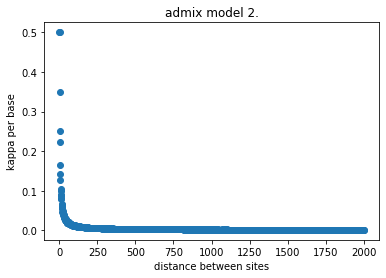

[0.00273742]


In [263]:
res_admixture_2 = [find_max_like_single_dist(x) for x in test_admixture_2[:]]
x,y = zip(*res_admixture_2)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("admix model 2.")
plt.show()
print(HeRho_estimate_one_chromosome(test_admixture_2))

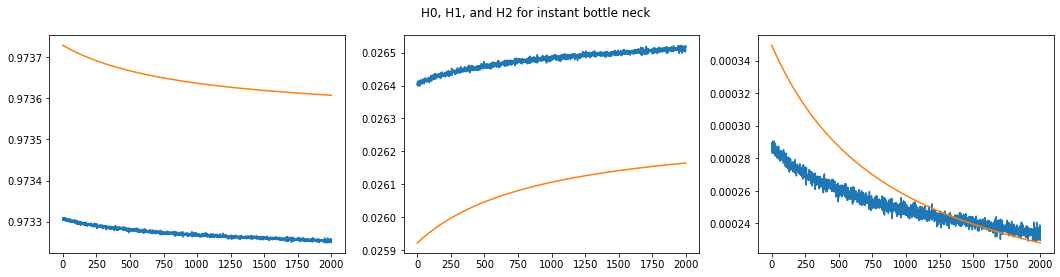

In [264]:
observed_hProbs_admixture_2 = np.apply_along_axis(lambda x: x/sum(x),1,test_admixture_2[:,[1,2,3]])
expected_hProbs_admixture_2 = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_admixture_2])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_admixture_2[:,x])
    axs[x].plot(expected_hProbs_admixture_2[:,x])
plt.show()

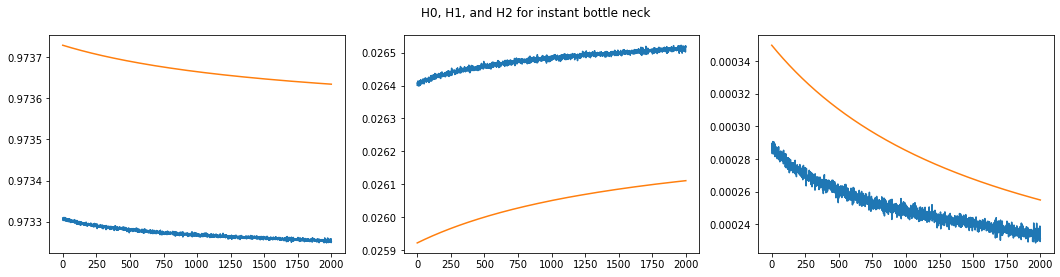

In [265]:
observed_hProbs_admixture_2 = np.apply_along_axis(lambda x: x/sum(x),1,test_admixture_2[:,[1,2,3]])
expected_hProbs_admixture_2 = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_admixture_2])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_admixture_2[:,x])
    axs[x].plot(expected_hProbs_admixture_2[:,x])
plt.show()

##### __admixture model 3__
time to admixture is (0.5) 2 Ne gens
duration of divergence is (2.0)2 Ne gens
so time to divergence is (0.5 + 2.0) 2 Ne gens

In [213]:
test_admixture_3 = sim_admixture([0,0.5,2.0])
test_admixture_3 = np.array(test_admixture_3)

In [214]:
print(test_admixture_3.tolist())

[[1.0, 48875638.0, 1110024.0, 12338.0, 0.011347453898155925], [2.0, 48875794.0, 1109712.0, 12494.0, 0.011347453898155927], [3.0, 48875543.0, 1110214.0, 12243.0, 0.011347453898155927], [4.0, 48875539.0, 1110222.0, 12239.0, 0.011347453898155927], [5.0, 48875658.0, 1109984.0, 12358.0, 0.011347453898155927], [6.0, 48875623.0, 1110054.0, 12323.0, 0.011347453898155927], [7.0, 48875684.0, 1109932.0, 12384.0, 0.011347453898155927], [8.0, 48875795.0, 1109710.0, 12495.0, 0.011347453898155927], [9.0, 48875438.0, 1110424.0, 12138.0, 0.011347453898155927], [10.0, 48875567.0, 1110166.0, 12267.0, 0.011347453898155927], [11.0, 48875406.0, 1110488.0, 12106.0, 0.011347453898155927], [12.0, 48875640.0, 1110020.0, 12340.0, 0.011347453898155927], [13.0, 48875552.0, 1110196.0, 12252.0, 0.011347453898155925], [14.0, 48875703.0, 1109894.0, 12403.0, 0.011347453898155927], [15.0, 48875543.0, 1110214.0, 12243.0, 0.011347453898155927], [16.0, 48875544.0, 1110212.0, 12244.0, 0.011347453898155925], [17.0, 48875499.

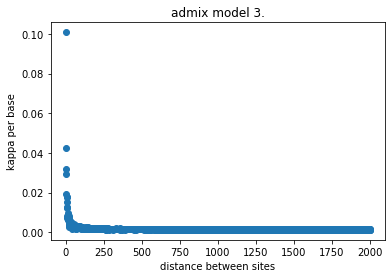

[0.00141733]


In [215]:
res_admixture_3 = [find_max_like_single_dist(x) for x in test_admixture_3[:]]
x,y = zip(*res_admixture_3)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("admix model 3.")
plt.show()
print(HeRho_estimate_one_chromosome(test_admixture_3))

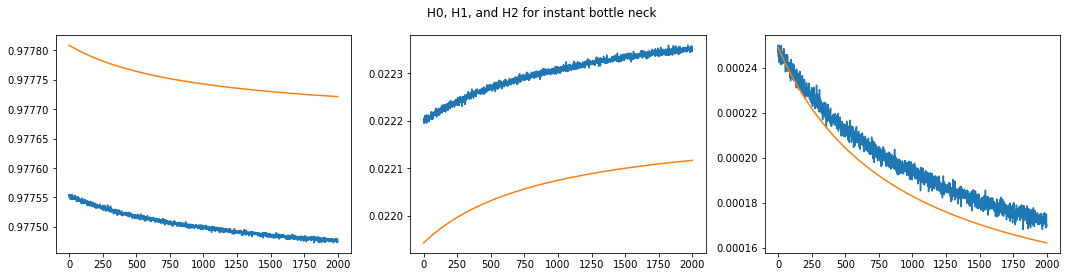

In [216]:
observed_hProbs_admixture_3 = np.apply_along_axis(lambda x: x/sum(x),1,test_admixture_3[:,[1,2,3]])
expected_hProbs_admixture_3 = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_admixture_3])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_admixture_3[:,x])
    axs[x].plot(expected_hProbs_admixture_3[:,x])
plt.show()

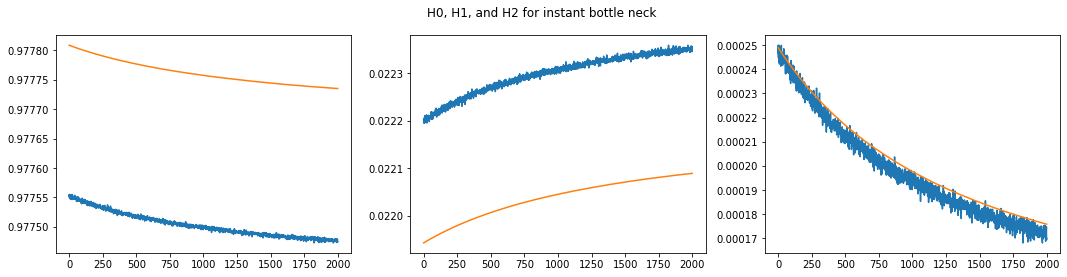

In [217]:
observed_hProbs_admixture_3 = np.apply_along_axis(lambda x: x/sum(x),1,test_admixture_3[:,[1,2,3]])
expected_hProbs_admixture_3 = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_admixture_3])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_admixture_3[:,x])
    axs[x].plot(expected_hProbs_admixture_3[:,x])
plt.show()

##### __admixture model 4__ 
time to admixture is (0.75) 2 Ne gens
duration of divergence is (2.0)2 Ne gens
so time to divergence is (0.75 + 2.0) 2 Ne gens

In [218]:
test_admixture_4 = sim_admixture([0,0.75,2.0])
test_admixture_4 = np.array(test_admixture_4)

In [219]:
print(test_admixture_4.tolist())

[[1.0, 48959604.0, 1027180.0, 11216.0, 0.010496539861594463], [2.0, 48959650.0, 1027088.0, 11262.0, 0.010496539861594465], [3.0, 48959784.0, 1026820.0, 11396.0, 0.010496539861594463], [4.0, 48959824.0, 1026740.0, 11436.0, 0.010496539861594463], [5.0, 48959875.0, 1026638.0, 11487.0, 0.010496539861594463], [6.0, 48959590.0, 1027208.0, 11202.0, 0.010496539861594465], [7.0, 48959605.0, 1027178.0, 11217.0, 0.010496539861594463], [8.0, 48959632.0, 1027124.0, 11244.0, 0.010496539861594463], [9.0, 48959884.0, 1026620.0, 11496.0, 0.010496539861594463], [10.0, 48959685.0, 1027018.0, 11297.0, 0.010496539861594465], [11.0, 48959808.0, 1026772.0, 11420.0, 0.010496539861594463], [12.0, 48959801.0, 1026786.0, 11413.0, 0.010496539861594463], [13.0, 48959864.0, 1026660.0, 11476.0, 0.010496539861594463], [14.0, 48959672.0, 1027044.0, 11284.0, 0.010496539861594463], [15.0, 48959729.0, 1026930.0, 11341.0, 0.010496539861594463], [16.0, 48959746.0, 1026896.0, 11358.0, 0.010496539861594463], [17.0, 48959942.

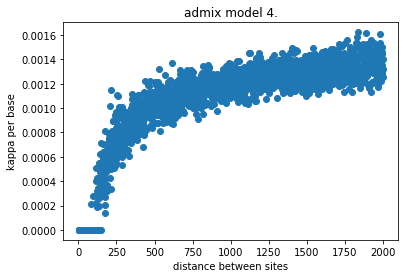

[0.00120567]


In [220]:
res_admixture_4 = [find_max_like_single_dist(x) for x in test_admixture_4[:]]
x,y = zip(*res_admixture_4)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("admix model 4.")
plt.show()
print(HeRho_estimate_one_chromosome(test_admixture_4))

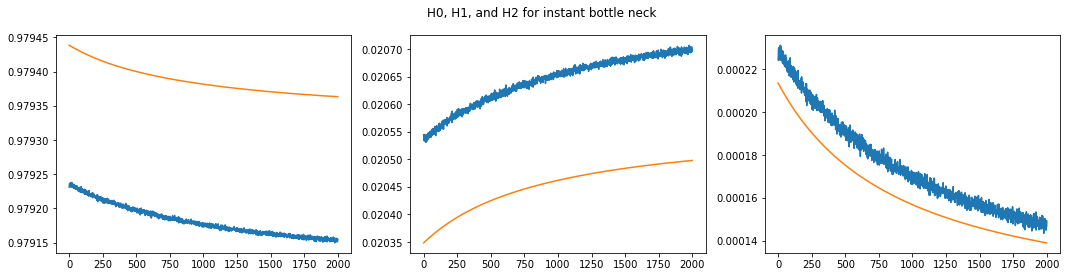

In [221]:
observed_hProbs_admixture_4 = np.apply_along_axis(lambda x: x/sum(x),1,test_admixture_4[:,[1,2,3]])
expected_hProbs_admixture_4 = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_admixture_4])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_admixture_4[:,x])
    axs[x].plot(expected_hProbs_admixture_4[:,x])
plt.show()

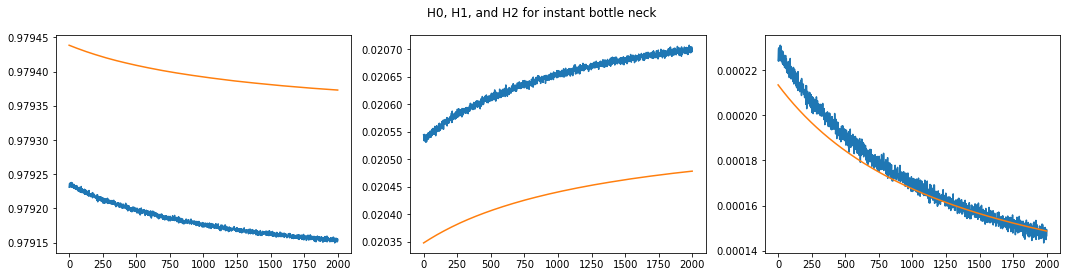

In [222]:
observed_hProbs_admixture_4 = np.apply_along_axis(lambda x: x/sum(x),1,test_admixture_4[:,[1,2,3]])
expected_hProbs_admixture_4 = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_admixture_4])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_admixture_4[:,x])
    axs[x].plot(expected_hProbs_admixture_4[:,x])
plt.show()

##### __admixture model 5__ 
time to admixture is (1.25) 2 Ne gens. This makes 1/2 prob of coal before admix
duration of divergence is (2.0)2 Ne gens
so time to divergence is (1.25 + 2.0) 2 Ne gens

In [223]:
test_admixture_5 = sim_admixture([0,1.25,2.0])
test_admixture_5 = np.array(test_admixture_5)

In [224]:
print(test_admixture_5.tolist())

[[1.0, 49102119.0, 886438.0, 9443.0, 0.009053602144085763], [2.0, 49102033.0, 886610.0, 9357.0, 0.009053602144085763], [3.0, 49102165.0, 886346.0, 9489.0, 0.009053602144085763], [4.0, 49101930.0, 886816.0, 9254.0, 0.009053602144085763], [5.0, 49102172.0, 886332.0, 9496.0, 0.009053602144085765], [6.0, 49101887.0, 886902.0, 9211.0, 0.009053602144085763], [7.0, 49102023.0, 886630.0, 9347.0, 0.009053602144085763], [8.0, 49102002.0, 886672.0, 9326.0, 0.009053602144085765], [9.0, 49101978.0, 886720.0, 9302.0, 0.009053602144085763], [10.0, 49101995.0, 886686.0, 9319.0, 0.009053602144085763], [11.0, 49102150.0, 886376.0, 9474.0, 0.009053602144085763], [12.0, 49101758.0, 887160.0, 9082.0, 0.009053602144085763], [13.0, 49101879.0, 886918.0, 9203.0, 0.009053602144085763], [14.0, 49101996.0, 886684.0, 9320.0, 0.009053602144085763], [15.0, 49101907.0, 886862.0, 9231.0, 0.009053602144085763], [16.0, 49102215.0, 886246.0, 9539.0, 0.009053602144085763], [17.0, 49101868.0, 886940.0, 9192.0, 0.009053602

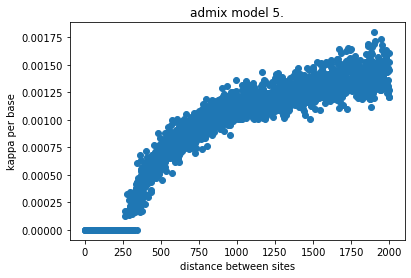

[0.00108992]


In [225]:
res_admixture_5 = [find_max_like_single_dist(x) for x in test_admixture_5[:]]
x,y = zip(*res_admixture_5)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("admix model 5.")
plt.show()
print(HeRho_estimate_one_chromosome(test_admixture_5))

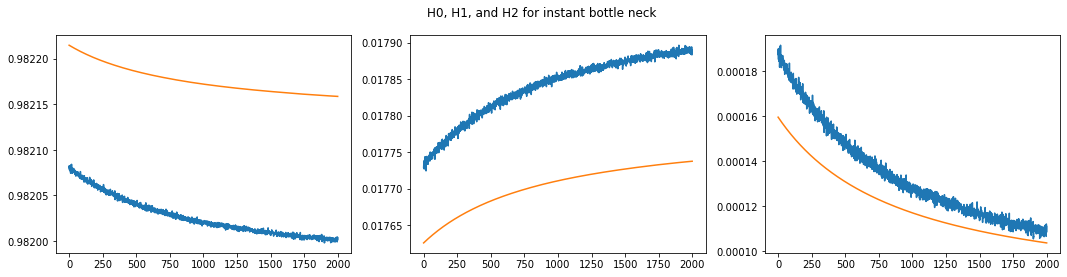

In [226]:
observed_hProbs_admixture_5 = np.apply_along_axis(lambda x: x/sum(x),1,test_admixture_5[:,[1,2,3]])
expected_hProbs_admixture_5 = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_admixture_5])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_admixture_5[:,x])
    axs[x].plot(expected_hProbs_admixture_5[:,x])
plt.show()

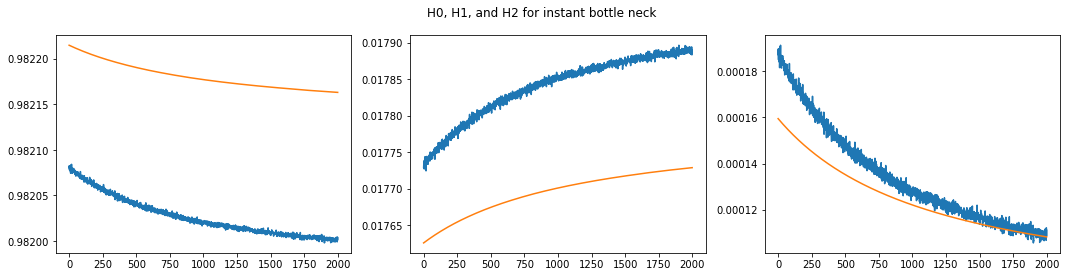

In [227]:
observed_hProbs_admixture_5 = np.apply_along_axis(lambda x: x/sum(x),1,test_admixture_5[:,[1,2,3]])
expected_hProbs_admixture_5 = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_admixture_5])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_admixture_5[:,x])
    axs[x].plot(expected_hProbs_admixture_5[:,x])
plt.show()

##### __admixture model 6__ 

time to admixture is (2.0) 2 Ne gens. 
duration of divergence is (2.0)2 Ne gens
so time to divergence is (2.0 + 2.0) 2 Ne gens

In [228]:
test_admixture_6 = sim_admixture([0,2.0,2.0])
test_admixture_6 = np.array(test_admixture_6)

In [229]:
print(test_admixture_6.tolist())

[[1.0, 49196970.0, 793324.0, 7706.0, 0.008087683507340295], [2.0, 49196926.0, 793412.0, 7662.0, 0.008087683507340295], [3.0, 49196911.0, 793442.0, 7647.0, 0.008087683507340295], [4.0, 49196898.0, 793468.0, 7634.0, 0.008087683507340293], [5.0, 49196831.0, 793602.0, 7567.0, 0.008087683507340293], [6.0, 49196842.0, 793580.0, 7578.0, 0.008087683507340295], [7.0, 49196937.0, 793390.0, 7673.0, 0.008087683507340293], [8.0, 49196912.0, 793440.0, 7648.0, 0.008087683507340293], [9.0, 49196930.0, 793404.0, 7666.0, 0.008087683507340293], [10.0, 49196983.0, 793298.0, 7719.0, 0.008087683507340293], [11.0, 49197075.0, 793114.0, 7811.0, 0.008087683507340293], [12.0, 49196915.0, 793434.0, 7651.0, 0.008087683507340293], [13.0, 49196842.0, 793580.0, 7578.0, 0.008087683507340295], [14.0, 49197090.0, 793084.0, 7826.0, 0.008087683507340293], [15.0, 49196992.0, 793280.0, 7728.0, 0.008087683507340293], [16.0, 49196799.0, 793666.0, 7535.0, 0.008087683507340295], [17.0, 49196869.0, 793526.0, 7605.0, 0.008087683

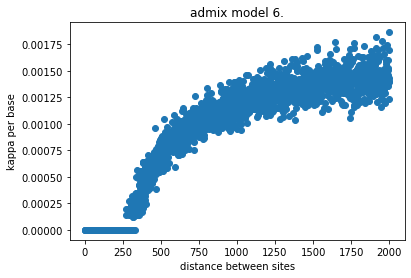

[0.00113303]


In [230]:
res_admixture_6 = [find_max_like_single_dist(x) for x in test_admixture_6[:]]
x,y = zip(*res_admixture_6)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("admix model 6.")
plt.show()
print(HeRho_estimate_one_chromosome(test_admixture_6))

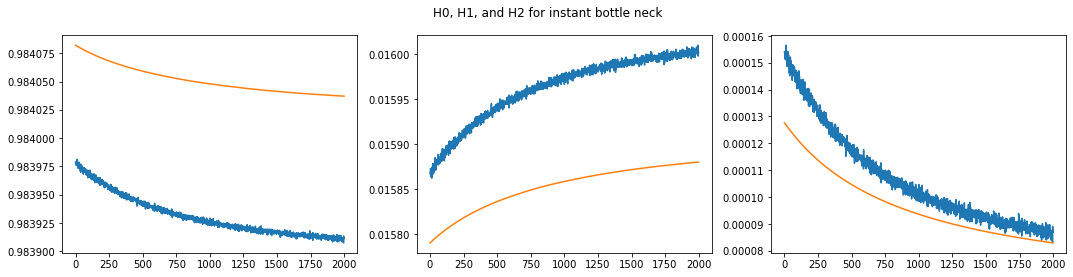

In [231]:
observed_hProbs_admixture_6 = np.apply_along_axis(lambda x: x/sum(x),1,test_admixture_6[:,[1,2,3]])
expected_hProbs_admixture_6 = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_admixture_6])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_admixture_6[:,x])
    axs[x].plot(expected_hProbs_admixture_6[:,x])
plt.show()

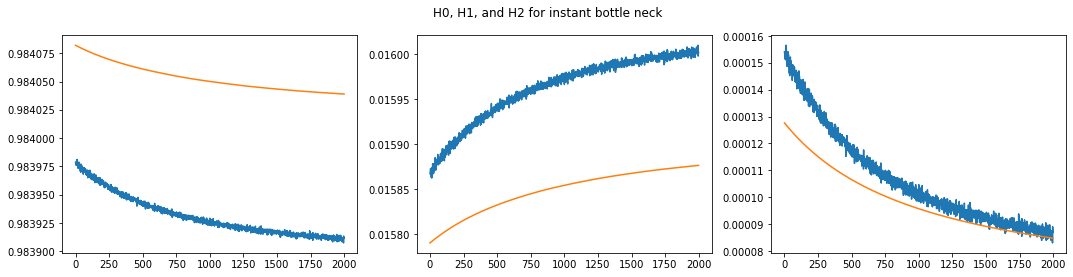

In [232]:
observed_hProbs_admixture_6 = np.apply_along_axis(lambda x: x/sum(x),1,test_admixture_6[:,[1,2,3]])
expected_hProbs_admixture_6 = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_admixture_6])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_admixture_6[:,x])
    axs[x].plot(expected_hProbs_admixture_6[:,x])
plt.show()

##### admixture scaled results combined

true scaled rho/theta = r/mu = 0.0017/0.0071 = 0.239437

In [266]:
# scaledRes_admixture_1 = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_admixture_1,test_admixture_1[:,-1],scaled_rho_expected))];
# scaledRes_admixture_2 = [ (a,b/c) for ((a,b),c) in list(zip(res_admixture_2,test_admixture_2[:,-1]))];
# scaledRes_admixture_3 = [ (a,b/c) for ((a,b),c) in list(zip(res_admixture_3,test_admixture_3[:,-1]))];
# scaledRes_admixture_4 = [ (a,b/c) for ((a,b),c) in list(zip(res_admixture_4,test_admixture_4[:,-1]))];
# scaledRes_admixture_5 = [ (a,b/c) for ((a,b),c) in list(zip(res_admixture_5,test_admixture_5[:,-1]))];
# scaledRes_admixture_6 = [ (a,b/c) for ((a,b),c) in list(zip(res_admixture_6,test_admixture_6[:,-1]))];

scaledRes_admixture_1 = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_admixture_1,test_admixture_1[:,-1],scaled_rho_expected))];
scaledRes_admixture_2 = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_admixture_2,test_admixture_2[:,-1],scaled_rho_expected))];
scaledRes_admixture_3 = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_admixture_3,test_admixture_3[:,-1],scaled_rho_expected))];
scaledRes_admixture_4 = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_admixture_4,test_admixture_4[:,-1],scaled_rho_expected))];
scaledRes_admixture_5 = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_admixture_5,test_admixture_5[:,-1],scaled_rho_expected))];
scaledRes_admixture_6 = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_admixture_6,test_admixture_6[:,-1],scaled_rho_expected))];


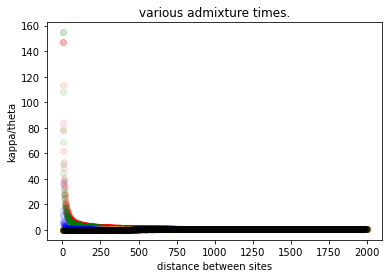

In [267]:
x,y = zip(*scaledRes_admixture_1)
plt.scatter(x,y,color='red',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_admixture_2)
plt.scatter(x,y,color='green',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_admixture_3)
plt.scatter(x,y,color='blue',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_admixture_4)
plt.scatter(x,y,color='orange',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_admixture_5)
plt.scatter(x,y,color='yellow',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_admixture_6)
plt.scatter(x,y,color='black',alpha=0.1,edgecolors=None)


plt.xlabel("distance between sites")
plt.ylabel("kappa/theta")
plt.title("various admixture times.")
plt.show()

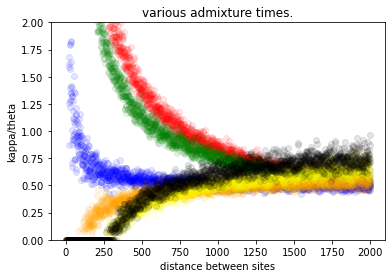

In [268]:
x,y = zip(*scaledRes_admixture_1)
plt.scatter(x,y,color='red',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_admixture_2)
plt.scatter(x,y,color='green',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_admixture_3)
plt.scatter(x,y,color='blue',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_admixture_4)
plt.scatter(x,y,color='orange',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_admixture_5)
plt.scatter(x,y,color='yellow',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_admixture_6)
plt.scatter(x,y,color='black',alpha=0.1,edgecolors=None)

plt.ylim(0,2.0)
plt.xlabel("distance between sites")
plt.ylabel("kappa/theta")
plt.title("various admixture times.")
plt.show()

## structured pop with two demes and long-term migration

##### Sim_structured function defined

In [236]:
def sim_structured(args):
    itt, M = args
    #itt = identifier, 
    #M = (pastward) migration rate on coal scale
        
    theta = 0.0071
    rho = 0.0017
    mu = 5.4e-9
    Ne = theta/(4*mu)
    Ne = Ne * 1.0
    r = rho/(4*Ne)
    L=50e6
    maxDistance = 2000
    
    m = M/(2*2*Ne)

    
    ##currently chosen to match probabilites to the instantaneous bottleneck model


    demography = msprime.Demography()
    a = demography.island_model([Ne,Ne],m)

    #This sets up a single neutral simulation given the parameters above: 
    ts = msprime.sim_ancestry(
        samples={"pop_0":1,"pop_1":0},
        demography=a,
        ploidy=2,
        recombination_rate=r,
        sequence_length=L,
        discrete_genome=False,
    )

    mts = msprime.sim_mutations(ts, rate=mu)
    #print(mts.num_trees)
    #print(mts.num_mutations)


    # #records an array of ALL sites, indicating whether the site is homozygous (0) or heterozygous (1)
    # hetStates = np.zeros(int(L),dtype=int)
    # for x in mts.variants():
    #     hetStates[int(x.position)] = 1

    hetStates = get_het_states(mts)
    firstCompareSeq = get_compare_seq(hetStates)
    start = time.time()
    g = rolling_window(hetStates,firstCompareSeq, maxDistance)
    countsByDistance = sum(g)

    res = countsByDistance.transpose()
    resNorm = np.apply_along_axis(lambda x: x/sum(x),1,res)

    resDF = pd.DataFrame(data = res,columns=["h0","h1","h2"])
    resDF["theta"]=[1/2*p1 + p2 for p0,p1,p2 in resNorm]
    
    heroInput = [[a,b,c,d,e] for (a,[b,c,d,e]) in list(zip(range(1,2000+1),resDF.values.tolist()))]
    #heroInput = pd.DataFrame(heroInput,columns=["d","h0","h1","h2","H"])
    return(heroInput)

#####  structured pop, single itt for range of M values: 
L = 50Mb for each replicate
M = {5e-15, 5e-6, 5e-5, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 5e0, 5e1, 5e2 }
M in coal time scale units. so per-gen rate is M/(4*Ne), converted in the sim function

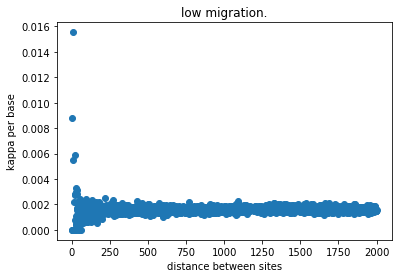

[0.00160867]


In [264]:
test_structure_1 = sim_structured([0,5e-15])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()
print(find_max_like_whole_chr(test_structure_1))

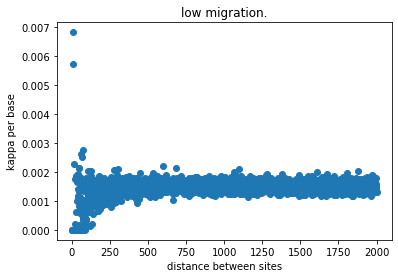

[0.00149497]


In [265]:
test_structure_1 = sim_structured([0,5e-6])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()
print(find_max_like_whole_chr(test_structure_1))

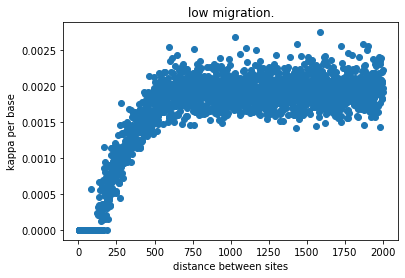

[0.00181058]


In [266]:
test_structure_1 = sim_structured([0,5e-5])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()
print(find_max_like_whole_chr(test_structure_1))

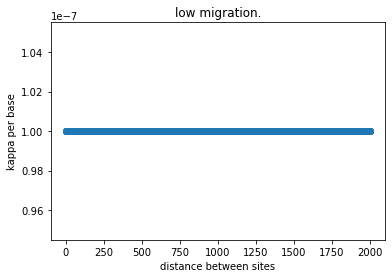

[0.0001]


In [267]:
test_structure_1 = sim_structured([0,5e-4])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()
print(find_max_like_whole_chr(test_structure_1))

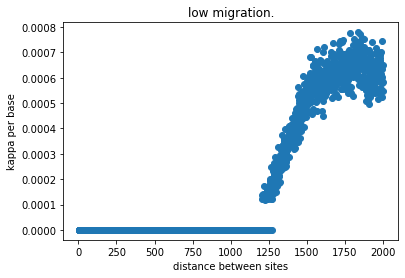

[0.0001]


In [268]:
test_structure_1 = sim_structured([0,1e-3])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()
print(find_max_like_whole_chr(test_structure_1))

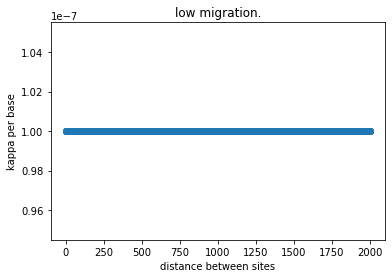

[0.0001]


In [269]:
test_structure_1 = sim_structured([0,5e-3])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()
print(find_max_like_whole_chr(test_structure_1))

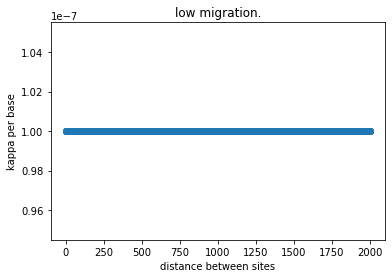

[0.0001]


In [270]:
test_structure_1 = sim_structured([0,1e-2])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()
print(find_max_like_whole_chr(test_structure_1))

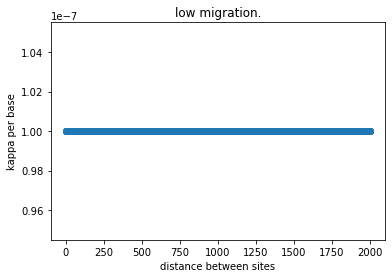

[0.0001]


In [271]:
test_structure_1 = sim_structured([0,5e-2])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()
print(find_max_like_whole_chr(test_structure_1))

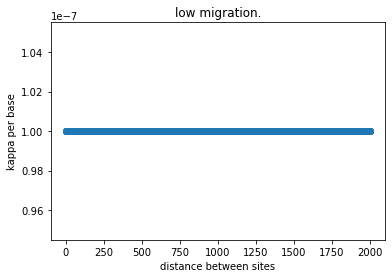

[0.0001]


In [272]:
test_structure_1 = sim_structured([0,1e-1])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()
print(find_max_like_whole_chr(test_structure_1))

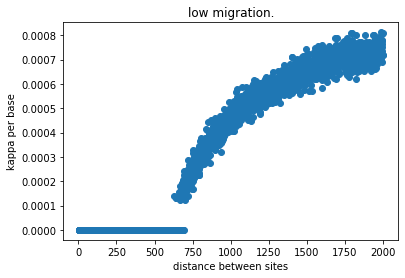

[0.00046301]


In [273]:
test_structure_1 = sim_structured([0,5e-1])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()
print(find_max_like_whole_chr(test_structure_1))

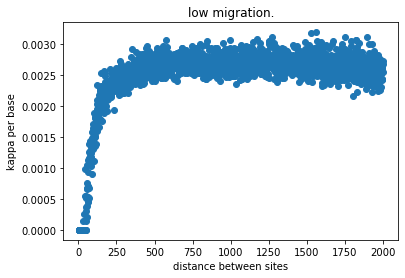

[0.00263507]


In [274]:
test_structure_1 = sim_structured([0,5e0])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()
print(find_max_like_whole_chr(test_structure_1))

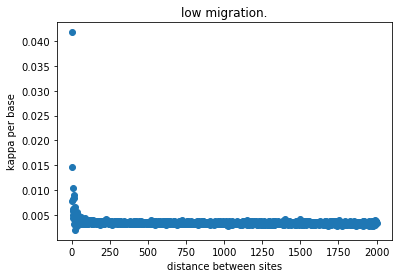

[0.00343053]


In [275]:
test_structure_1 = sim_structured([0,5e1])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()
print(find_max_like_whole_chr(test_structure_1))

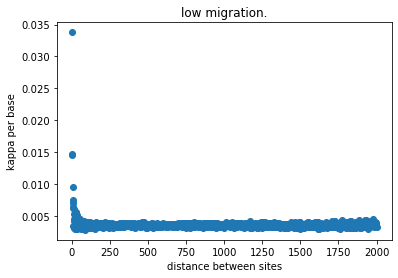

[0.00353473]


In [276]:
test_structure_1 = sim_structured([0,5e2])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()
print(find_max_like_whole_chr(test_structure_1))

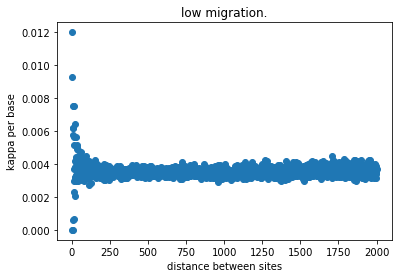

[0.00351426]


In [277]:
test_structure_1 = sim_structured([0,5e3])
test_structure_1 = np.array(test_structure_1)

res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()
print(find_max_like_whole_chr(test_structure_1))

#####  structured pop M = 5e-5 
M in coal time scale units. so per-gen rate is M/(4*Ne), converted in the sim function

In [237]:
test_structure_1 = sim_structured([0,5e-5])
test_structure_1 = np.array(test_structure_1)

In [238]:
print(test_structure_1.tolist())

[[1.0, 49277243.0, 715648.0, 5109.0, 0.007258950358014321], [2.0, 49277245.0, 715644.0, 5111.0, 0.007258950358014321], [3.0, 49277209.0, 715716.0, 5075.0, 0.007258950358014321], [4.0, 49277169.0, 715796.0, 5035.0, 0.007258950358014321], [5.0, 49277180.0, 715774.0, 5046.0, 0.007258950358014321], [6.0, 49277240.0, 715654.0, 5106.0, 0.007258950358014321], [7.0, 49277163.0, 715808.0, 5029.0, 0.007258950358014321], [8.0, 49277034.0, 716066.0, 4900.0, 0.007258950358014321], [9.0, 49277257.0, 715621.0, 5122.0, 0.007258940357614305], [10.0, 49277104.0, 715927.0, 4969.0, 0.007258940357614305], [11.0, 49277143.0, 715849.0, 5008.0, 0.007258940357614305], [12.0, 49277203.0, 715729.0, 5068.0, 0.007258940357614305], [13.0, 49277258.0, 715619.0, 5123.0, 0.007258940357614305], [14.0, 49277109.0, 715917.0, 4974.0, 0.007258940357614305], [15.0, 49277237.0, 715661.0, 5102.0, 0.007258940357614305], [16.0, 49277270.0, 715595.0, 5135.0, 0.007258940357614305], [17.0, 49277317.0, 715501.0, 5182.0, 0.007258940

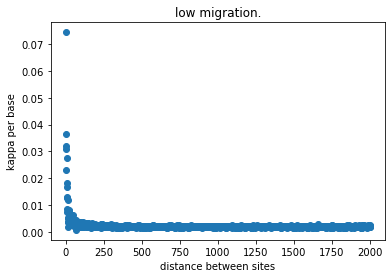

[0.00200142]


In [239]:
res_structure_1 = [find_max_like_single_dist(x) for x in test_structure_1[:]]
x,y = zip(*res_structure_1)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("low migration.")
plt.show()
print(HeRho_estimate_one_chromosome(test_structure_1))

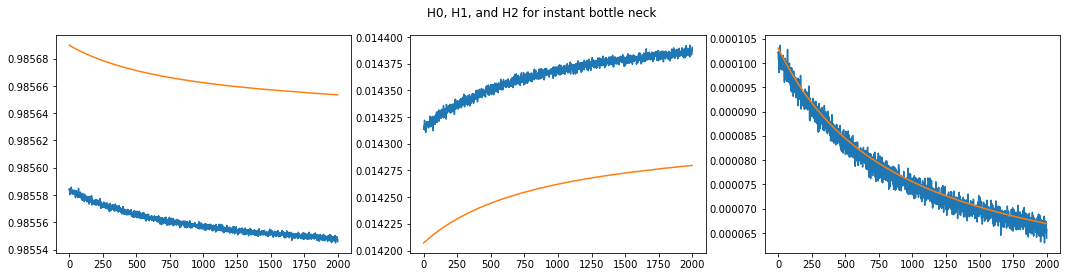

In [240]:
observed_hProbs_structure_1 = np.apply_along_axis(lambda x: x/sum(x),1,test_structure_1[:,[1,2,3]])
expected_hProbs_structure_1 = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_structure_1])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_structure_1[:,x])
    axs[x].plot(expected_hProbs_structure_1[:,x])
plt.show()

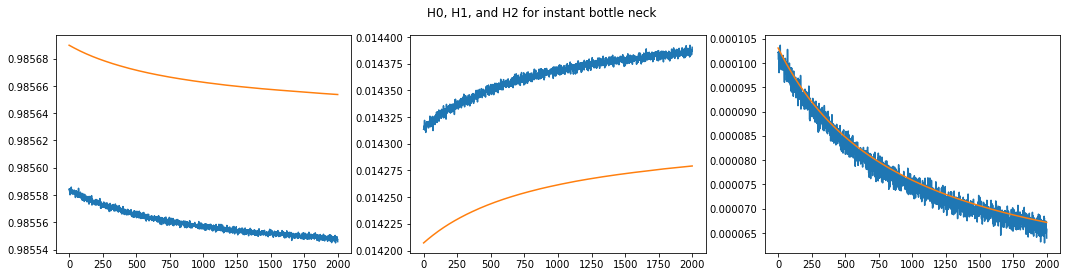

In [241]:

observed_hProbs_structure_1 = np.apply_along_axis(lambda x: x/sum(x),1,test_structure_1[:,[1,2,3]])
expected_hProbs_structure_1 = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_structure_1])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_structure_1[:,x])
    axs[x].plot(expected_hProbs_structure_1[:,x])
plt.show()

##### structured pop M = 5e-3

In [269]:
test_structure_2 = sim_structured([0,5e-3])
test_structure_2 = np.array(test_structure_2)

In [270]:
print(test_structure_2.tolist())

[[1.0, 48978974.0, 818830.0, 200196.0, 0.012192707708308333], [2.0, 48978643.0, 819492.0, 199865.0, 0.012192707708308333], [3.0, 48978459.0, 819860.0, 199681.0, 0.012192707708308333], [4.0, 48978291.0, 820196.0, 199513.0, 0.012192707708308333], [5.0, 48978109.0, 820560.0, 199331.0, 0.012192707708308333], [6.0, 48977781.0, 821216.0, 199003.0, 0.012192707708308333], [7.0, 48977609.0, 821560.0, 198831.0, 0.012192707708308333], [8.0, 48977599.0, 821580.0, 198821.0, 0.012192707708308333], [9.0, 48977411.0, 821956.0, 198633.0, 0.012192707708308333], [10.0, 48977220.0, 822338.0, 198442.0, 0.012192707708308333], [11.0, 48976846.0, 823086.0, 198068.0, 0.012192707708308333], [12.0, 48976784.0, 823210.0, 198006.0, 0.012192707708308333], [13.0, 48976774.0, 823230.0, 197996.0, 0.012192707708308333], [14.0, 48976520.0, 823738.0, 197742.0, 0.012192707708308333], [15.0, 48976205.0, 824368.0, 197427.0, 0.012192707708308333], [16.0, 48976061.0, 824656.0, 197283.0, 0.012192707708308333], [17.0, 48976214.

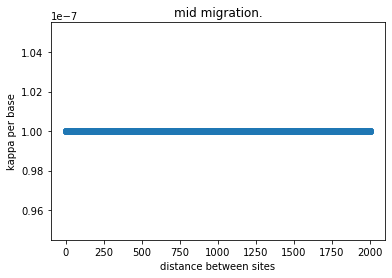

[1.e-07]


In [271]:
res_structure_2 = [find_max_like_single_dist(x) for x in test_structure_2[:]]
x,y = zip(*res_structure_2)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("mid migration.")
plt.show()
print(HeRho_estimate_one_chromosome(test_structure_2))

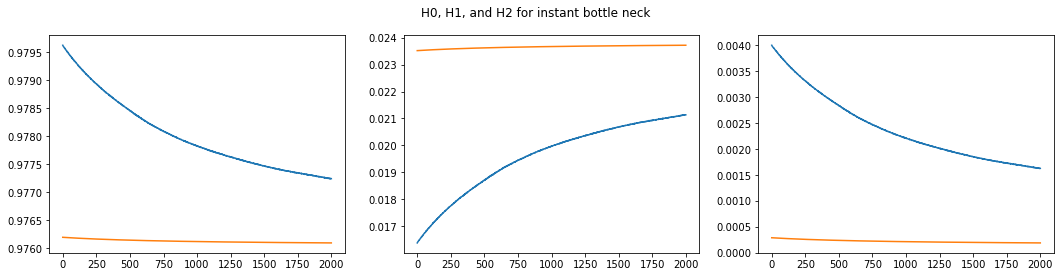

In [272]:
observed_hProbs_structure_2 = np.apply_along_axis(lambda x: x/sum(x),1,test_structure_2[:,[1,2,3]])
expected_hProbs_structure_2 = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_structure_2])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_structure_2[:,x])
    axs[x].plot(expected_hProbs_structure_2[:,x])
plt.show()

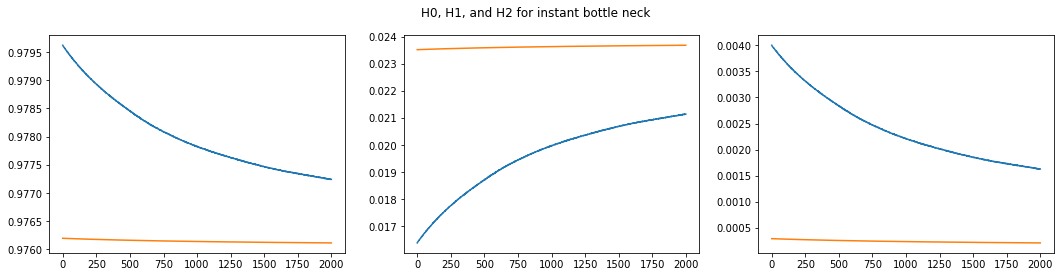

In [273]:
observed_hProbs_structure_2 = np.apply_along_axis(lambda x: x/sum(x),1,test_structure_2[:,[1,2,3]])
expected_hProbs_structure_2 = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_structure_2])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_structure_2[:,x])
    axs[x].plot(expected_hProbs_structure_2[:,x])
plt.show()

##### structured pop M = 5e-1

In [247]:
test_structure_3 = sim_structured([0,5e-1])
test_structure_3 = np.array(test_structure_3)

In [248]:
print(test_structure_3.tolist())

[[1.0, 48636119.0, 1334054.0, 27827.0, 0.013897635905436218], [2.0, 48635999.0, 1334294.0, 27707.0, 0.013897635905436218], [3.0, 48635984.0, 1334324.0, 27692.0, 0.013897635905436218], [4.0, 48635952.0, 1334388.0, 27660.0, 0.013897635905436218], [5.0, 48636147.0, 1333998.0, 27855.0, 0.013897635905436218], [6.0, 48635976.0, 1334340.0, 27684.0, 0.013897635905436218], [7.0, 48636137.0, 1334018.0, 27845.0, 0.013897635905436218], [8.0, 48636196.0, 1333900.0, 27904.0, 0.013897635905436218], [9.0, 48635910.0, 1334472.0, 27618.0, 0.013897635905436218], [10.0, 48635924.0, 1334444.0, 27632.0, 0.013897635905436218], [11.0, 48635870.0, 1334552.0, 27578.0, 0.013897635905436218], [12.0, 48635980.0, 1334332.0, 27688.0, 0.013897635905436218], [13.0, 48635897.0, 1334498.0, 27605.0, 0.013897635905436218], [14.0, 48635681.0, 1334930.0, 27389.0, 0.013897635905436218], [15.0, 48636015.0, 1334262.0, 27723.0, 0.013897635905436218], [16.0, 48635680.0, 1334932.0, 27388.0, 0.013897635905436218], [17.0, 48635144.

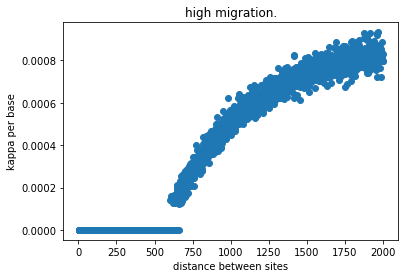

[0.00051931]


In [249]:
res_structure_3 = [find_max_like_single_dist(x) for x in test_structure_3[:]]
x,y = zip(*res_structure_3)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("high migration.")
plt.show()
print(HeRho_estimate_one_chromosome(test_structure_3))

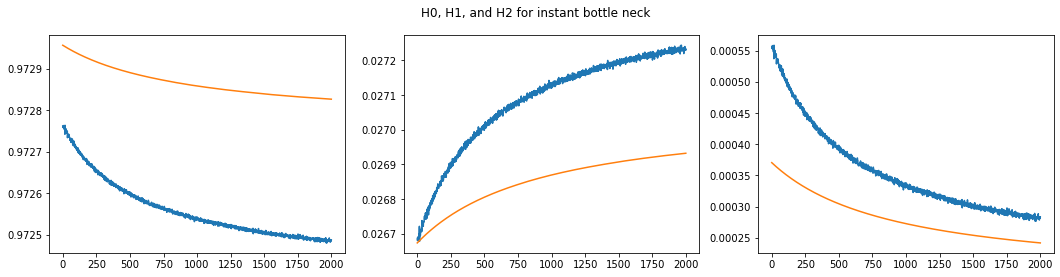

In [250]:
observed_hProbs_structure_3 = np.apply_along_axis(lambda x: x/sum(x),1,test_structure_3[:,[1,2,3]])
expected_hProbs_structure_3 = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_structure_3])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_structure_3[:,x])
    axs[x].plot(expected_hProbs_structure_3[:,x])
plt.show()

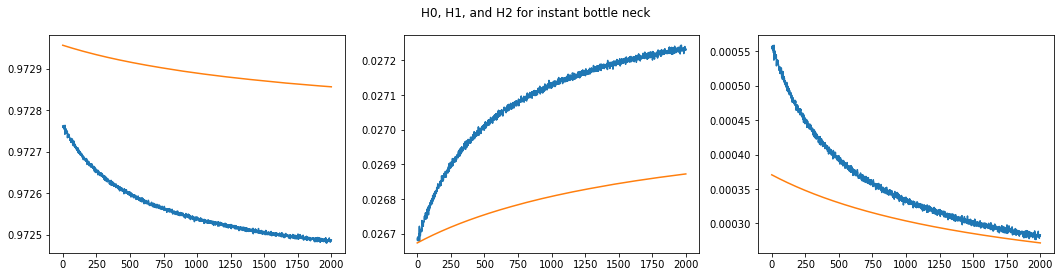

In [251]:
observed_hProbs_structure_3 = np.apply_along_axis(lambda x: x/sum(x),1,test_structure_3[:,[1,2,3]])
expected_hProbs_structure_3 = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_structure_3])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_structure_3[:,x])
    axs[x].plot(expected_hProbs_structure_3[:,x])
plt.show()

##### structured pop M = 5e1

In [252]:
test_structure_4 = sim_structured([0,5e1])
test_structure_4 = np.array(test_structure_4)

In [253]:
print(test_structure_4.tolist())

[[1.0, 48616344.0, 1362360.0, 19296.0, 0.014010080403216128], [2.0, 48616440.0, 1362168.0, 19392.0, 0.014010080403216128], [3.0, 48616270.0, 1362508.0, 19222.0, 0.014010080403216128], [4.0, 48616230.0, 1362588.0, 19182.0, 0.01401008040321613], [5.0, 48616301.0, 1362446.0, 19253.0, 0.014010080403216128], [6.0, 48616106.0, 1362836.0, 19058.0, 0.014010080403216128], [7.0, 48616222.0, 1362604.0, 19174.0, 0.01401008040321613], [8.0, 48616042.0, 1362964.0, 18994.0, 0.014010080403216128], [9.0, 48616043.0, 1362962.0, 18995.0, 0.014010080403216128], [10.0, 48616021.0, 1363006.0, 18973.0, 0.014010080403216128], [11.0, 48616053.0, 1362942.0, 19005.0, 0.01401008040321613], [12.0, 48616006.0, 1363036.0, 18958.0, 0.014010080403216128], [13.0, 48616155.0, 1362739.0, 19106.0, 0.014010070402816113], [14.0, 48615929.0, 1363192.0, 18879.0, 0.014010060402416097], [15.0, 48615859.0, 1363332.0, 18809.0, 0.014010060402416097], [16.0, 48616216.0, 1362618.0, 19166.0, 0.014010060402416097], [17.0, 48616099.0, 

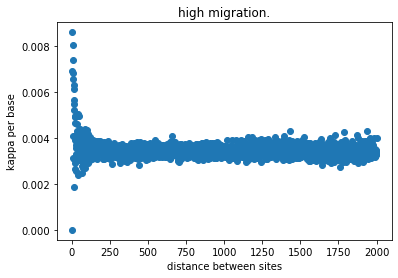

[0.00343828]


In [254]:
res_structure_4 = [find_max_like_single_dist(x) for x in test_structure_4[:]]
x,y = zip(*res_structure_4)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("high migration.")
plt.show()
print(HeRho_estimate_one_chromosome(test_structure_4))

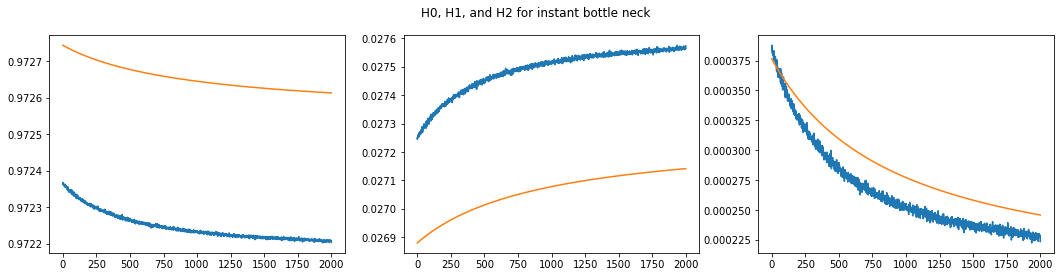

In [255]:
observed_hProbs_structure_4 = np.apply_along_axis(lambda x: x/sum(x),1,test_structure_4[:,[1,2,3]])
expected_hProbs_structure_4 = np.array([two_locus_het_probs(x[-1],0.0017,x[0]) for x in test_structure_4])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_structure_4[:,x])
    axs[x].plot(expected_hProbs_structure_4[:,x])
plt.show()

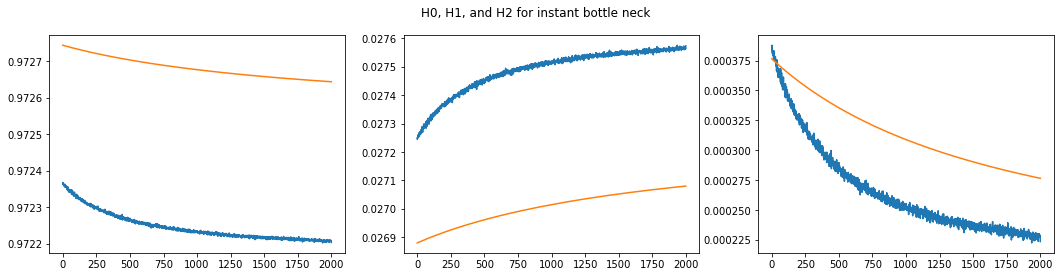

In [256]:
observed_hProbs_structure_4 = np.apply_along_axis(lambda x: x/sum(x),1,test_structure_4[:,[1,2,3]])
expected_hProbs_structure_4 = np.array([two_locus_het_probs(x[-1],0.0017*0.0071/x[-1],x[0]) for x in test_structure_4])

fig, axs = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("H0, H1, and H2 for instant bottle neck")
for x in [0,1,2]:
    axs[x].plot(observed_hProbs_structure_4[:,x])
    axs[x].plot(expected_hProbs_structure_4[:,x])
plt.show()

##### structure results combined -- scaled rho/theta -- these are the old results with replicates and converged to good answer

The single-iterations don't have such nice results

Migration rates increase from blue to red to green

In [257]:
scaledRes_structure_1 = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_structure_1,test_structure_1[:,-1],scaled_rho_expected))];
scaledRes_structure_2 = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_structure_2,test_structure_2[:,-1],scaled_rho_expected))];
scaledRes_structure_3 = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_structure_3,test_structure_3[:,-1],scaled_rho_expected))];
scaledRes_structure_4 = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_structure_4,test_structure_4[:,-1],scaled_rho_expected))];
#scaledRes_structure_2 = [ (a,b/c) for ((a,b),c) in list(zip(res_structure_2,test_structure_2[:,-1]))];
#scaledRes_structure_3 = [ (a,b/c) for ((a,b),c) in list(zip(res_structure_3,test_structure_3[:,-1]))];

In [258]:
print("true rho/theta = 0.239437")
print([a[1] for a in scaledRes_structure_1[-6:-1]])
print([a[1] for a in scaledRes_structure_2[-6:-1]])
print([a[1] for a in scaledRes_structure_3[-6:-1]])
print([a[1] for a in scaledRes_structure_4[-6:-1]])

true rho/theta = 0.239437
[1.2682481974618398, 1.0238915730015639, 1.0705452189381242, 1.2891522209796649, 1.2508467801140712]
[4.8311292862591944e-05, 4.831129286259196e-05, 4.8311292862591944e-05, 4.831129286259196e-05, 4.8311292862591944e-05]
[0.24446016766571724, 0.24625888813511912, 0.25064301036663456, 0.23901530114629782, 0.23958573805446057]
[0.9755664172095132, 1.0275900516401633, 1.0113974260113348, 1.0396886833537315, 0.994441913011193]


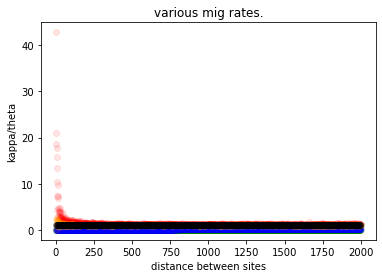

In [259]:
x,y = zip(*scaledRes_structure_1)
plt.scatter(x,y,color='red',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_structure_2)
plt.scatter(x,y,color='green',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_structure_3)
plt.scatter(x,y,color='blue',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_structure_4)
plt.scatter(x,y,color='orange',alpha=0.1,edgecolors=None)

x=range(1,2000)
y=[1 for x in range(1,2000)]
plt.scatter(x,y,color='black',alpha=0.1,edgecolors=None)

plt.xlabel("distance between sites")
plt.ylabel("kappa/theta")
plt.title("various mig rates.")
plt.show()

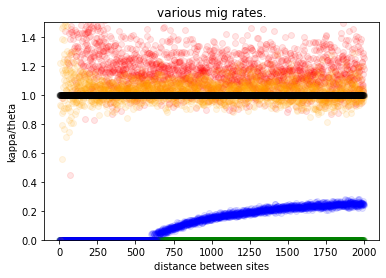

In [260]:
x,y = zip(*scaledRes_structure_1)
plt.scatter(x,y,color='red',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_structure_2)
plt.scatter(x,y,color='green',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_structure_3)
plt.scatter(x,y,color='blue',alpha=0.1,edgecolors=None)

x,y = zip(*scaledRes_structure_4)
plt.scatter(x,y,color='orange',alpha=0.1,edgecolors=None)

x=range(1,2000)
y=[1 for x in range(1,2000)]
plt.scatter(x,y,color='black',alpha=0.1,edgecolors=None)


plt.ylim(0,1.5)
plt.xlabel("distance between sites")
plt.ylabel("kappa/theta")
plt.title("various mig rates.")
plt.show()

Migration rates increase from blue to red to green

# Recombination rate variation

In [85]:
def sim_basic_rec_vary(args):
    itt, rho = args
    
    theta = 0.0071

    mu = 5.4e-9
    Ne = theta/(4*mu)
    r = rho/(4*Ne)
    L=50e6
    maxDistance = 2000


    #This sets up a single neutral simulation given the parameters above: 
    ts = msprime.sim_ancestry(
        samples=1,
        model=[msprime.StandardCoalescent()],
        ploidy=2,
        population_size=Ne,
        recombination_rate=r,
        sequence_length=L,
        discrete_genome=False,
    )

    mts = msprime.sim_mutations(ts, rate=mu)
    #print(mts.num_trees)
    #print(mts.num_mutations)


    # #records an array of ALL sites, indicating whether the site is homozygous (0) or heterozygous (1)
    # hetStates = np.zeros(int(L),dtype=int)
    # for x in mts.variants():
    #     hetStates[int(x.position)] = 1

    hetStates = get_het_states(mts)
    firstCompareSeq = get_compare_seq(hetStates)
    start = time.time()
    g = rolling_window(hetStates,firstCompareSeq, maxDistance)
    countsByDistance = sum(g)

    res = countsByDistance.transpose()
    resNorm = np.apply_along_axis(lambda x: x/sum(x),1,res)

    resDF = pd.DataFrame(data = res,columns=["h0","h1","h2"])
    resDF["theta"]=[1/2*p1 + p2 for p0,p1,p2 in resNorm]
    
    heroInput = [[a,b,c,d,e] for (a,[b,c,d,e]) in list(zip(range(1,2000+1),resDF.values.tolist()))]
    #heroInput = pd.DataFrame(heroInput,columns=["d","h0","h1","h2","H"])
    return(heroInput)
    

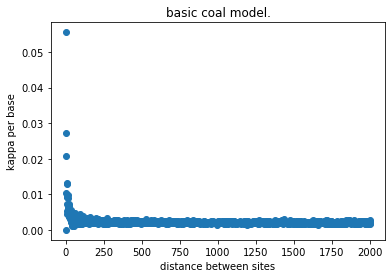

[0.00211306]


In [86]:
test_low_rec = sim_basic_rec_vary([0,0.002])
test_low_rec = np.array(test_low_rec)

res_low_rec = [find_max_like_single_dist(x) for x in test_low_rec[:]]
x,y = zip(*res_low_rec)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("basic coal model.")
plt.show()
print(find_max_like_whole_chr(test_low_rec))

In [87]:
print(test_low_rec.tolist())

[[1.0, 49301689.0, 691462.0, 4849.0, 0.007011880475219008], [2.0, 49301556.0, 691728.0, 4716.0, 0.007011880475219009], [3.0, 49301724.0, 691392.0, 4884.0, 0.007011880475219009], [4.0, 49301657.0, 691526.0, 4817.0, 0.007011880475219009], [5.0, 49301521.0, 691798.0, 4681.0, 0.007011880475219009], [6.0, 49301636.0, 691568.0, 4796.0, 0.007011880475219009], [7.0, 49301585.0, 691670.0, 4745.0, 0.007011880475219009], [8.0, 49301654.0, 691532.0, 4814.0, 0.007011880475219009], [9.0, 49301546.0, 691748.0, 4706.0, 0.007011880475219009], [10.0, 49301583.0, 691674.0, 4743.0, 0.007011880475219008], [11.0, 49301599.0, 691642.0, 4759.0, 0.007011880475219009], [12.0, 49301639.0, 691562.0, 4799.0, 0.007011880475219009], [13.0, 49301602.0, 691636.0, 4762.0, 0.007011880475219009], [14.0, 49301611.0, 691618.0, 4771.0, 0.007011880475219009], [15.0, 49301508.0, 691824.0, 4668.0, 0.007011880475219009], [16.0, 49301571.0, 691698.0, 4731.0, 0.007011880475219009], [17.0, 49301498.0, 691844.0, 4658.0, 0.007011880

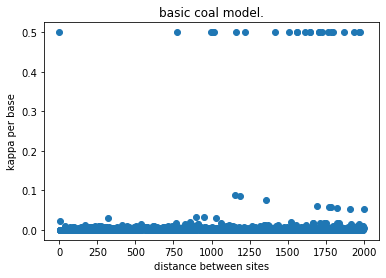

[0.00494976]


In [96]:
test_mid_rec_1 = sim_basic_rec_vary([0,0.005])
test_mid_rec_1 = np.array(test_mid_rec_1)

res_mid_rec_1 = [find_max_like_single_dist(x) for x in test_mid_rec_1[:]]
x,y = zip(*res_mid_rec)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("basic coal model.")
plt.show()

print(find_max_like_whole_chr(test_mid_rec_1))

In [97]:
print(test_mid_rec_1.tolist())

[[1.0, 49298026.0, 695102.0, 4872.0, 0.007048741949677987], [2.0, 49298134.0, 694886.0, 4980.0, 0.007048741949677987], [3.0, 49297988.0, 695178.0, 4834.0, 0.007048741949677987], [4.0, 49297994.0, 695166.0, 4840.0, 0.007048741949677987], [5.0, 49298023.0, 695108.0, 4869.0, 0.007048741949677987], [6.0, 49298032.0, 695090.0, 4878.0, 0.007048741949677987], [7.0, 49298068.0, 695018.0, 4914.0, 0.007048741949677987], [8.0, 49297946.0, 695262.0, 4792.0, 0.007048741949677987], [9.0, 49297998.0, 695158.0, 4844.0, 0.007048741949677987], [10.0, 49298028.0, 695098.0, 4874.0, 0.007048741949677987], [11.0, 49298071.0, 695012.0, 4917.0, 0.007048741949677987], [12.0, 49298016.0, 695122.0, 4862.0, 0.007048741949677987], [13.0, 49298072.0, 695010.0, 4918.0, 0.007048741949677987], [14.0, 49298006.0, 695142.0, 4852.0, 0.007048741949677987], [15.0, 49298050.0, 695054.0, 4896.0, 0.007048741949677987], [16.0, 49297965.0, 695224.0, 4811.0, 0.007048741949677987], [17.0, 49297889.0, 695376.0, 4735.0, 0.007048741

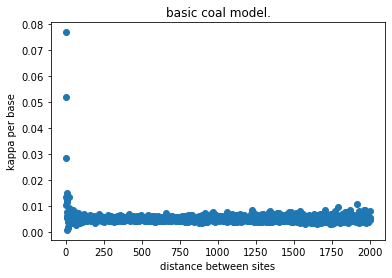

[0.00508986]


In [98]:
test_mid_rec_2 = sim_basic_rec_vary([0,0.005])
test_mid_rec_2 = np.array(test_mid_rec_2)

res_mid_rec_2 = [find_max_like_single_dist(x) for x in test_mid_rec_2[:]]
x,y = zip(*res_mid_rec_2)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("basic coal model.")
plt.show()
print(find_max_like_whole_chr(test_mid_rec_2))

In [99]:
print(test_mid_rec_2.tolist())

[[1.0, 49298604.0, 694590.0, 4806.0, 0.007042301692067683], [2.0, 49298633.0, 694532.0, 4835.0, 0.007042301692067683], [3.0, 49298493.0, 694812.0, 4695.0, 0.007042301692067683], [4.0, 49298656.0, 694486.0, 4858.0, 0.007042301692067683], [5.0, 49298617.0, 694564.0, 4819.0, 0.007042301692067683], [6.0, 49298714.0, 694370.0, 4916.0, 0.007042301692067683], [7.0, 49298654.0, 694490.0, 4856.0, 0.007042301692067683], [8.0, 49298576.0, 694646.0, 4778.0, 0.007042301692067683], [9.0, 49298616.0, 694566.0, 4818.0, 0.007042301692067683], [10.0, 49298639.0, 694520.0, 4841.0, 0.007042301692067683], [11.0, 49298535.0, 694728.0, 4737.0, 0.007042301692067683], [12.0, 49298462.0, 694874.0, 4664.0, 0.007042301692067683], [13.0, 49298692.0, 694414.0, 4894.0, 0.007042301692067683], [14.0, 49298634.0, 694530.0, 4836.0, 0.007042301692067683], [15.0, 49298571.0, 694656.0, 4773.0, 0.007042301692067683], [16.0, 49298546.0, 694706.0, 4748.0, 0.0070423016920676835], [17.0, 49298672.0, 694454.0, 4874.0, 0.00704230

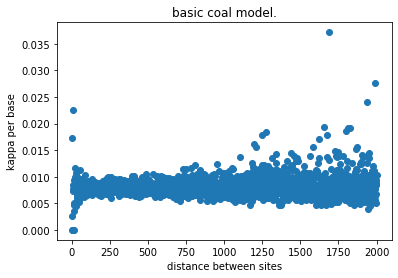

[0.00787708]


In [100]:
test_high_rec = sim_basic_rec_vary([0,0.008])
test_high_rec = np.array(test_high_rec)

res_high_rec = [find_max_like_single_dist(x) for x in test_high_rec[:]]
x,y = zip(*res_high_rec)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("basic coal model.")
plt.show()
print(find_max_like_whole_chr(test_high_rec))

In [101]:
print(test_high_rec.tolist())

[[1.0, 49302305.0, 690754.0, 4941.0, 0.007006640265610624], [2.0, 49302230.0, 690904.0, 4866.0, 0.007006640265610624], [3.0, 49302158.0, 691048.0, 4794.0, 0.007006640265610624], [4.0, 49302353.0, 690658.0, 4989.0, 0.007006640265610624], [5.0, 49302070.0, 691224.0, 4706.0, 0.007006640265610624], [6.0, 49302167.0, 691030.0, 4803.0, 0.007006640265610625], [7.0, 49302256.0, 690852.0, 4892.0, 0.007006640265610625], [8.0, 49302134.0, 691096.0, 4770.0, 0.007006640265610624], [9.0, 49302137.0, 691090.0, 4773.0, 0.007006640265610624], [10.0, 49302260.0, 690844.0, 4896.0, 0.007006640265610624], [11.0, 49302107.0, 691150.0, 4743.0, 0.007006640265610624], [12.0, 49302072.0, 691220.0, 4708.0, 0.007006640265610624], [13.0, 49302167.0, 691030.0, 4803.0, 0.007006640265610625], [14.0, 49302139.0, 691086.0, 4775.0, 0.007006640265610624], [15.0, 49302121.0, 691122.0, 4757.0, 0.007006640265610624], [16.0, 49302048.0, 691268.0, 4684.0, 0.007006640265610625], [17.0, 49301996.0, 691372.0, 4632.0, 0.007006640

In [102]:
print((0.00211306 + 0.00787708)/2)
print((0.00494976 + 0.00508986)/2)



0.00499507
0.0050198099999999996


In [103]:
mixed_low_high = combine_rep_results([test_low_rec,test_high_rec])
mixed_mid_mid = combine_rep_results([test_mid_rec_1,test_mid_rec_2])

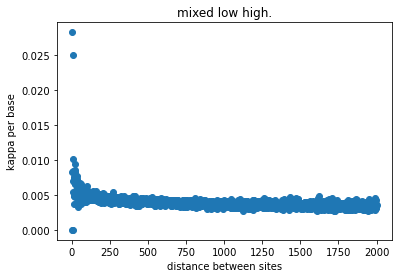

[0.00382907]


In [104]:
res_mixed_low_high = [find_max_like_single_dist(x) for x in mixed_low_high[:]]
x,y = zip(*res_mixed_low_high)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("mixed low high.")
plt.show()
print(find_max_like_whole_chr(mixed_low_high))

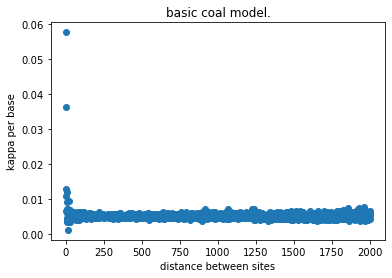

[0.00501914]


In [105]:
res_mixed_mid_mid = [find_max_like_single_dist(x) for x in mixed_mid_mid[:]]
x,y = zip(*res_mixed_mid_mid)
plt.scatter(x,y)
plt.xlabel("distance between sites")
plt.ylabel("kappa per base")
plt.title("basic coal model.")
plt.show()
print(find_max_like_whole_chr(mixed_mid_mid))

In [162]:
scaled_rho_expected_rec_vary_avg= [[d,0.005/0.0071] for d in range(1,2000)]

In [166]:
scaledRes_mixed_low_high = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_mixed_low_high,mixed_low_high[:,-1],scaled_rho_expected_rec_vary_avg))];
scaledRes_mixed_mid_mid = [ (a,b/c/e) for ((a,b),c,(d,e)) in list(zip(res_mixed_mid_mid,mixed_mid_mid[:,-1],scaled_rho_expected_rec_vary_avg))];

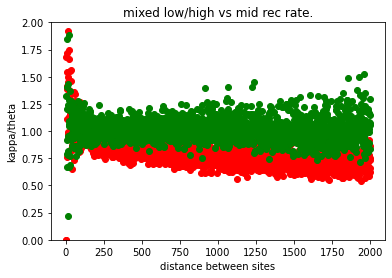

In [168]:
x,y = zip(*scaledRes_mixed_low_high)
plt.scatter(x,y,color='red')

x,y = zip(*scaledRes_mixed_mid_mid)
plt.scatter(x,y,color='green')

plt.ylim(0,2)
plt.xlabel("distance between sites")
plt.ylabel("kappa/theta")
plt.title("mixed low/high vs mid rec rate.")
plt.show()